In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode, pearsonr
import csv
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from datetime import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

%matplotlib inline

In [2]:
df = pd.read_csv('./data/train_fea_special.csv', sep=' ')
df['dataset'] = 2
# predictDf = pd.read_csv('./xgb1/test_fea.csv', sep=' ')
# predictDf['dataset'] = 2

print(df.iloc[:,:80].info())
print(df.iloc[:,80:160].info())
print(df.iloc[:,160:].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077175 entries, 0 to 1077174
Data columns (total 80 columns):
cate2_his_show               423649 non-null float64
prop_predict_ratio           619297 non-null float64
special_date_dist            1077175 non-null int64
cate_lastdate_show           1077175 non-null float64
shop_price_sum               1077175 non-null int64
shop_sales_delta             1077175 non-null float64
item_gender_ratio            1077175 non-null float64
us_lastdate_show             1077175 non-null float64
item_property_list_str       1077173 non-null object
shop_score_service_delta     1076951 non-null float64
bg_his_trade                 972277 non-null float64
item_lastdate_trade_delta    1053261 non-null float64
item_lastdate_show           1053261 non-null float64
user_next_show_timedelta     1077175 non-null float64
shop_star_level_mean         1077175 non-null float64
hour                         1077175 non-null int64
shop_score_delivery_delta    1076

None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077175 entries, 0 to 1077174
Data columns (total 86 columns):
uc_his_trade                    1077175 non-null float64
brand_collected_mean            972064 non-null float64
timestamp                       1077175 non-null int64
cg_his_show_ratio               1074879 non-null float64
shop_pv_mean                    1077175 non-null float64
ba_his_trade_delta              970210 non-null float64
shop_sales_mean                 1077175 non-null float64
shop_score_description_delta    1076951 non-null float64
brand_pv_delta                  972064 non-null float64
cate_his_trade_ratio            1077175 non-null float64
cate_price_mean                 1077175 non-null float64
shop_score_delivery             1076951 non-null float64
shop_age_mean                   1077175 non-null float64
uc_his_show                     1077175 non-null float64
ui_lastdate_trade               1077175 non-null float64
us_lasthour_show_ratio          

In [3]:
# 计算转化皮尔森系数
def getFeaPearsonr(df, cols):
    resultDf = pd.DataFrame(index=cols, columns=['pearsonr','p_values'])
    for c in cols:
        tempDf = df.dropna(subset=[c])
        result = pearsonr(tempDf[c].values, tempDf['is_trade'].values)
        resultDf.loc[c,:] = result
    return resultDf

In [4]:
# 单维度转化率评价
def printSingleFeaLine(df, cols, plot=True):
    tempDf = df.fillna(-9999)
    for c in cols:
        print(tempDf[c].value_counts())
        if plot:
            plt.figure(figsize=(15,5))
            sns.pointplot(x=c, y='is_trade', data=tempDf, hue='dataset',dodge=True)

In [5]:
# 矩估计法计算贝叶斯平滑参数
def countBetaParamByMME(inputArr):
    EX = inputArr.mean()
    EX2 = (inputArr ** 2).mean()
    alpha = (EX*(EX-EX2)) / (EX2 - EX**2)
    beta = alpha * (1/EX - 1)
    return alpha,beta

# 对numpy数组进行贝叶斯平滑处理
def biasSmooth(aArr, bArr, method='MME', alpha=None, beta=None):
    ratioArr = aArr / bArr
    if method=='MME':
        alpha,beta = countBetaParamByMME(ratioArr[ratioArr==ratioArr])
    resultArr = (aArr+alpha) / (bArr+alpha+beta)
    return resultArr

In [6]:
# 转化数据集字段格式，拆分组合特征
def formatDf(df):
    df.drop_duplicates(inplace=True)
    df['context_timestamp'] = df['timestamp'].map(lambda x: datetime.fromtimestamp(x))
    tempDf = df.drop_duplicates(subset=['item_id'])[['item_id','item_property_list_str']]
    tempDf['item_property_list'] = tempDf[tempDf.item_property_list_str.notnull()]['item_property_list_str'].map(lambda x: x.split(';'))
    df = df.merge(tempDf, how='left', on='item_id' )
    df['predict_category_property'] = df[df.predict_category_property_str.notnull()]['predict_category_property_str'].map(
        lambda x: {kv.split(':')[0]:(kv.split(':')[1].split(',') if kv.split(':')[1]!='-1' else []) for kv in x.split(';')})
    df['date'] = pd.to_datetime(df.context_timestamp.dt.date)
    return df

In [7]:
df = formatDf(df)

          pearsonr   p_values
minute -0.00254403  0.0082814
5     92819
6     91833
3     91591
4     91535
7     91054
2     90903
8     90232
9     89577
10    88954
11    88087
1     86990
0     83600
Name: minute, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


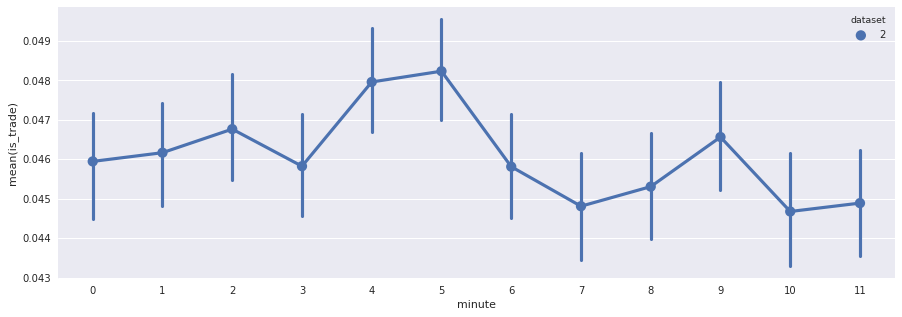

In [14]:
# 考虑分钟特征
tempDf = df.copy()
print(getFeaPearsonr(tempDf, ['minute']))
tempDf['minute'] = tempDf.minute // 5
printSingleFeaLine(tempDf, ['minute'])

                             pearsonr      p_values
shop_review_positive_rate  0.00774003   9.50479e-16
shop_score_service         -0.0230013  5.84047e-126
shop_score_delivery        -0.0269587  2.70904e-172
shop_score_description    -0.00552798   9.64978e-09
shop_star_level            0.00908848   3.99098e-21
shop_review_num_level      0.00865486   2.64001e-19
 199.0     687017
 198.0     181424
 197.0     100496
 196.0      44815
 195.0      22206
 194.0      16662
 193.0      10283
 192.0       6089
 191.0       2525
 189.0       2295
 190.0       2075
 188.0        513
 186.0        208
 187.0        179
 180.0        155
 185.0         96
 184.0         65
-9999.0        45
 182.0         20
 183.0          5
 181.0          2
Name: shop_review_positive_rate, dtype: int64
 195.0     227646
 194.0     195377
 193.0     189323
 196.0     153066
 192.0     128397
 191.0      61410
 197.0      61406
 190.0      20298
 198.0      15584
 199.0      13211
 189.0       5781
 188.0       2

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


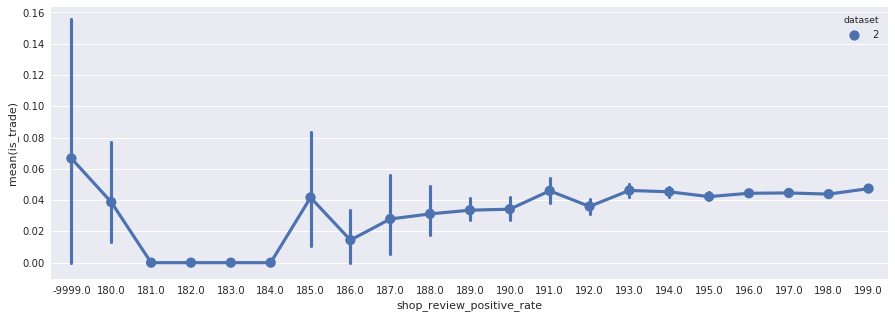

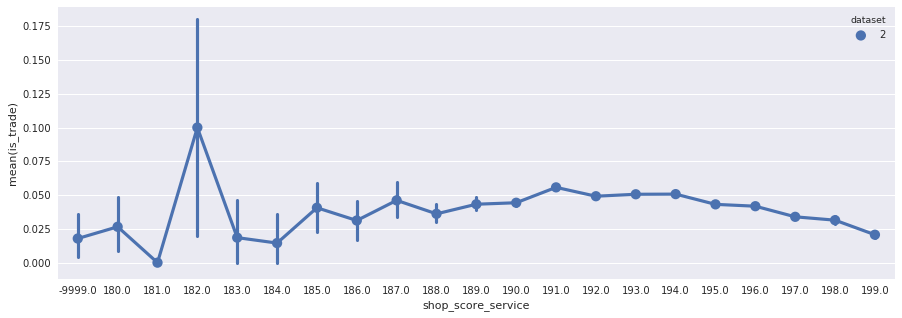

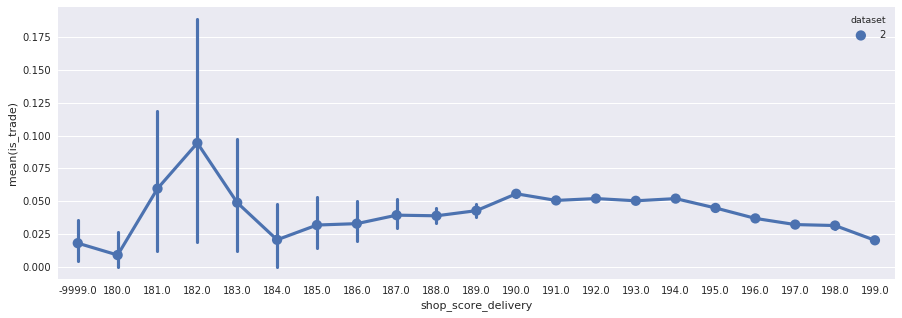

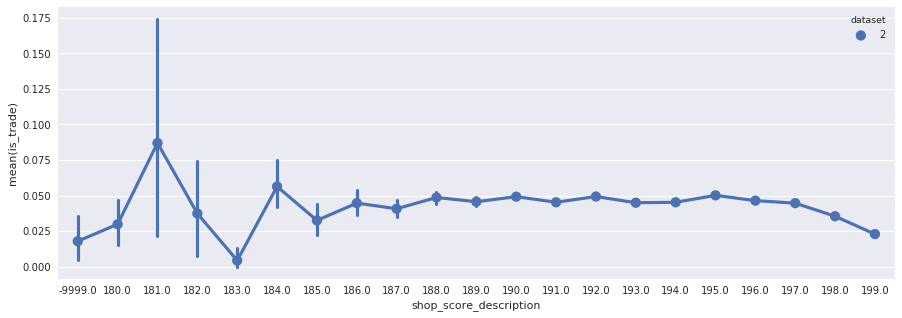

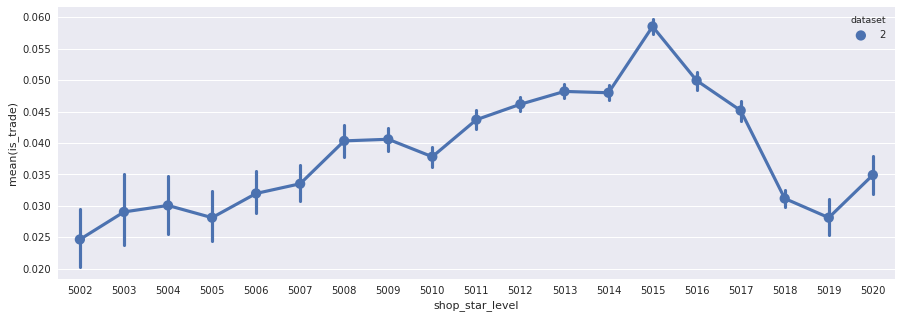

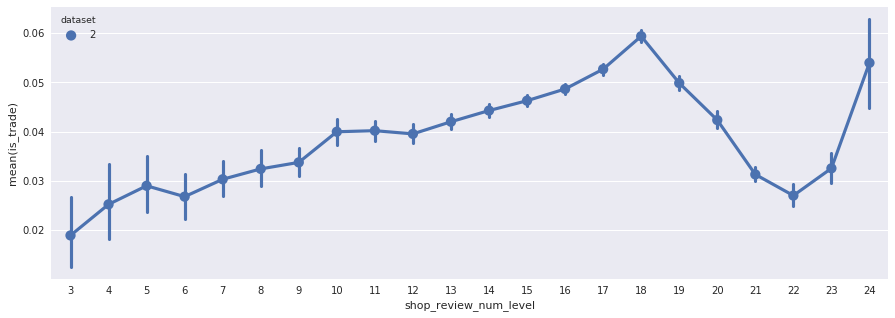

In [27]:
# 店铺特征
tempDf = df.copy()
cols = ['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description','shop_star_level','shop_review_num_level']
print(getFeaPearsonr(tempDf, cols))
# tempDf.loc[tempDf.shop_star_level<5002, 'shop_star_level'] = 5002
# tempDf.loc[tempDf.shop_review_num_level<4, 'shop_review_num_level'] = 3
# tempDf.loc[tempDf.shop_review_num_level>23, 'shop_review_num_level'] = 24
tempDf.loc[:,['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description']] = tempDf[['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description']] // 0.005
tempDf.loc[tempDf.shop_review_positive_rate<180, 'shop_review_positive_rate'] = 180
tempDf.loc[tempDf.shop_score_service<180, 'shop_score_service'] = 180
tempDf.loc[tempDf.shop_score_delivery<180, 'shop_score_delivery'] = 180
tempDf.loc[tempDf.shop_score_description<180, 'shop_score_description'] = 180
printSingleFeaLine(tempDf, cols)

                           pearsonr      p_values
context_page_id          -0.0217029  2.23753e-112
predict_cate_num         0.00257849    0.00745008
cate_intersect_num        0.0193516   9.87846e-90
predict_prop_num         0.00634419    5.9563e-07
prop_intersect_num        0.0160197    1.9183e-36
prop_jaccard             -0.0082363   9.07013e-11
prop_predict_ratio        0.0117251   2.77273e-20
prop_item_ratio         -0.00779851   8.40143e-10
prop_jaccard_bias        -0.0106974   3.80964e-17
prop_predict_ratio_bias   0.0123719   2.10751e-22
prop_item_ratio_bias     -0.0104265   2.29916e-16
4001    594979
4002    100201
4003     72737
4004     55801
4005     43500
4006     34865
4007     28779
4008     23713
4009     20002
4010     16756
4011     14546
4012     12947
4013     10967
4014      9765
4015      8406
4016      7465
4017      6531
4018      5627
4019      4996
4020      4592
Name: context_page_id, dtype: int64
 4.0       224372
 3.0       215064
 2.0       205621
 5.0      

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


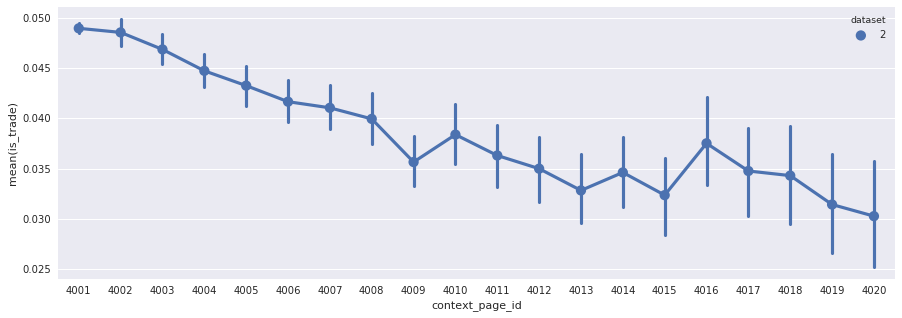

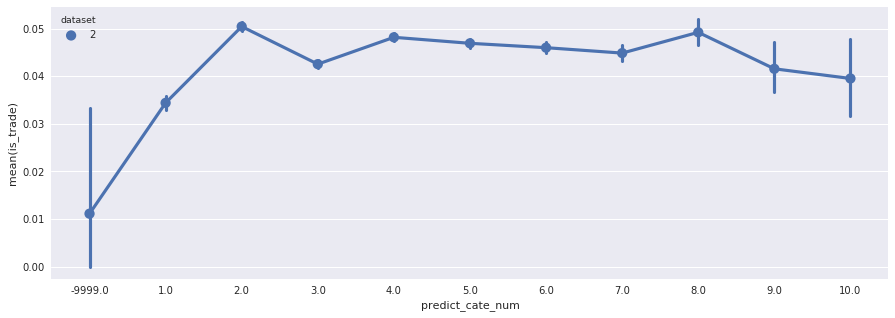

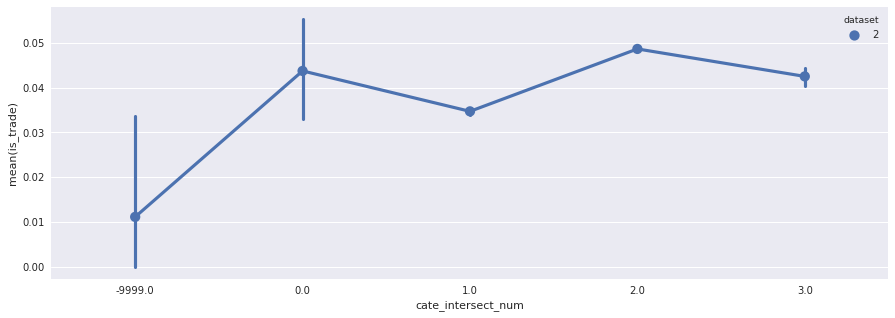

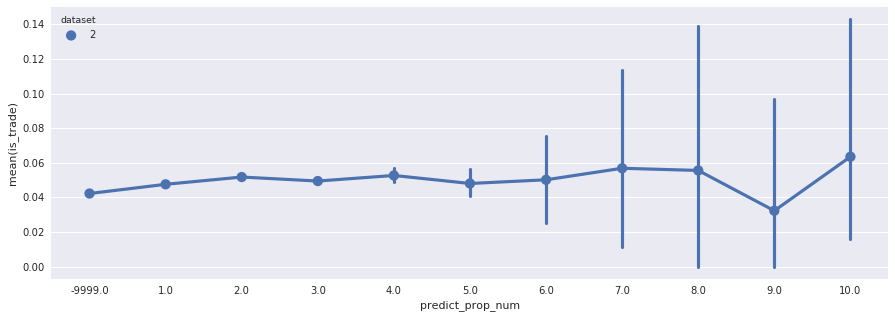

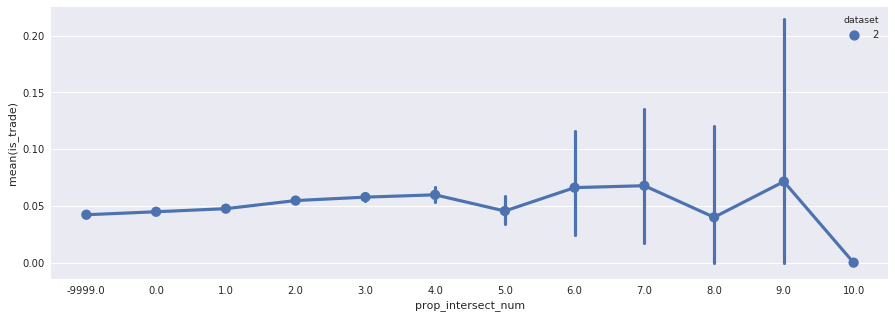

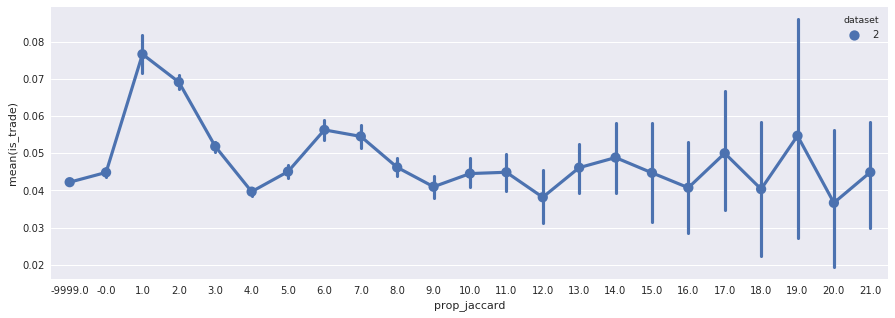

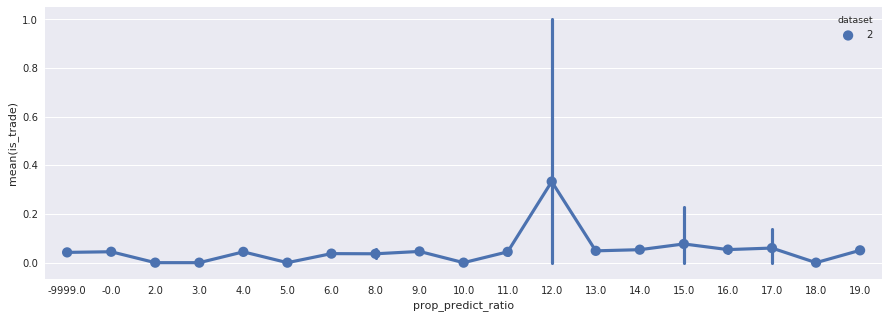

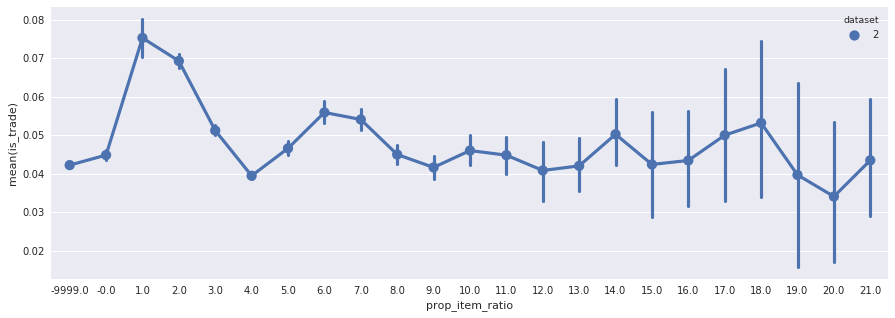

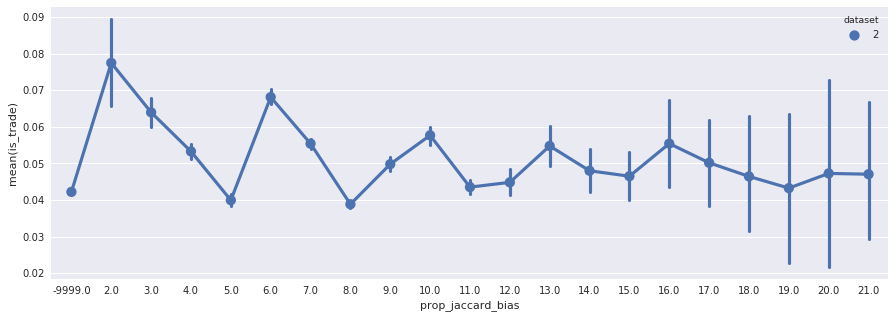

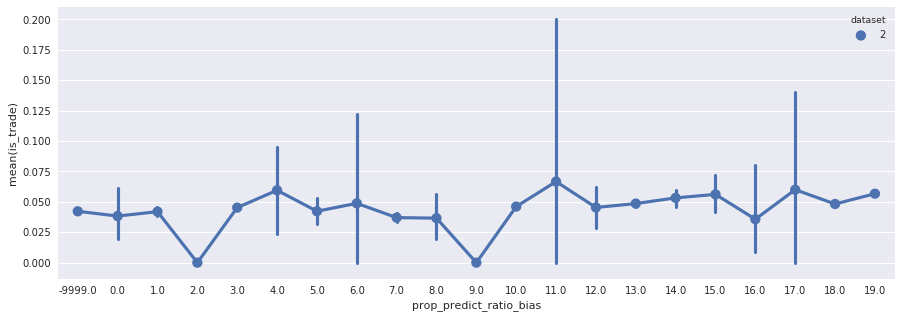

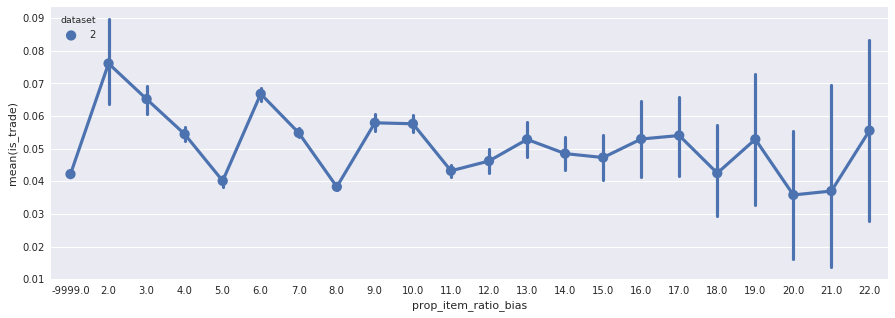

In [49]:
# 上下文特征
tempDf = df.copy()
cols = ['context_page_id','predict_cate_num','cate_intersect_num','predict_prop_num','prop_intersect_num',
        'prop_jaccard','prop_predict_ratio','prop_item_ratio','prop_jaccard_bias','prop_predict_ratio_bias','prop_item_ratio_bias']
print(getFeaPearsonr(tempDf, cols))
tempDf.loc[tempDf.predict_cate_num>10, 'predict_cate_num'] = 10
tempDf.loc[tempDf.predict_prop_num>10, 'predict_prop_num'] = 10
tempDf.loc[tempDf.prop_intersect_num>10, 'prop_intersect_num'] = 10
tempDf['prop_jaccard'] = tempDf['prop_jaccard'] // 0.01
tempDf.loc[tempDf.prop_jaccard>20, 'prop_jaccard'] = 21
tempDf['prop_predict_ratio'] = tempDf['prop_predict_ratio'] // 0.05
tempDf['prop_item_ratio'] = tempDf['prop_item_ratio'] // 0.01
tempDf.loc[tempDf.prop_item_ratio>20, 'prop_item_ratio'] = 21
tempDf['prop_jaccard_bias'] = tempDf['prop_jaccard_bias'] // 0.005
tempDf.loc[tempDf.prop_jaccard_bias>20, 'prop_jaccard_bias'] = 21
tempDf['prop_predict_ratio_bias'] = tempDf['prop_predict_ratio_bias'] // 0.05
tempDf['prop_item_ratio_bias'] = tempDf['prop_item_ratio_bias'] // 0.005
tempDf.loc[tempDf.prop_item_ratio_bias>21, 'prop_item_ratio_bias'] = 22
printSingleFeaLine(tempDf, cols)

In [13]:
# 查看各个id的粒度
print(df.item_id.value_counts())
print(df.item_brand_id.value_counts())
print(df.shop_id.value_counts())
print(df.user_id.value_counts())

8568467075407444807    3217
7933362890576371959    2771
333261466062930330     2160
5340996313837249587    2015
3811081381819802768    1949
3024739065628274403    1704
7969047545099689438    1659
7353997705966575396    1574
2740599886907219665    1457
8602414328436443727    1435
8881909419334931441    1373
3948722777398180782    1321
5806392056010953222    1209
9197583400310910637    1206
5359018227425298402    1203
3431758951552728219    1192
4343381103845111278    1157
7372427111152299381    1138
5228108543842840962    1121
3179897157347950390    1113
2824306521536280446    1099
798794043819966269     1083
205817875056766354     1081
1058765079786233558    1071
4385510570582881075    1065
8363638779510498577    1061
7472908180239041043    1060
3877784360598973165    1036
5719970115487190102    1008
7241377069590098874     997
                       ... 
1917487526361900133       1
5381684934369034539       1
2386294158461227805       1
4524795906717815942       1
2015258267859291555 

                             pearsonr      p_values
user_last_show_timedelta    0.0121728   1.36645e-36
user_next_show_timedelta    0.0744235             0
user_his_show              -0.0269218  7.29804e-172
user_his_trade             0.00475038   8.21024e-07
user_lasthour_show         -0.0129251   4.93199e-41
user_nexthour_show         -0.0560708             0
user_lastdate_show         -0.0138562   6.74641e-47
user_lastdate_trade        0.00419449    1.3407e-05
user_lastdate_trade_ratio  0.00608044   2.77671e-10
user_his_trade_ratio        0.0125888   5.14737e-39
user_near_timedelta         0.0594265             0
user_nearhour_show_delta   -0.0418983  4.29381e-291
16.0    593843
0.0     193838
1.0     101102
2.0      53904
3.0      33169
4.0      22446
5.0      16451
6.0      12241
7.0       9769
8.0       7949
9.0       6991
10.0      5803
11.0      4978
12.0      4202
13.0      3845
14.0      3461
15.0      3183
Name: user_last_show_timedelta, dtype: int64
16.0    581032
0.0     2

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


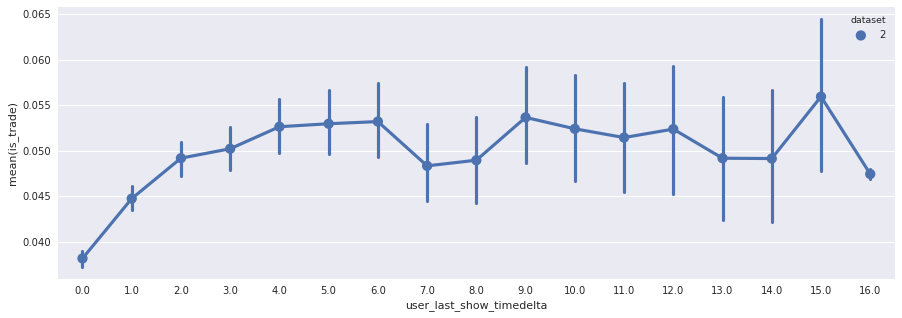

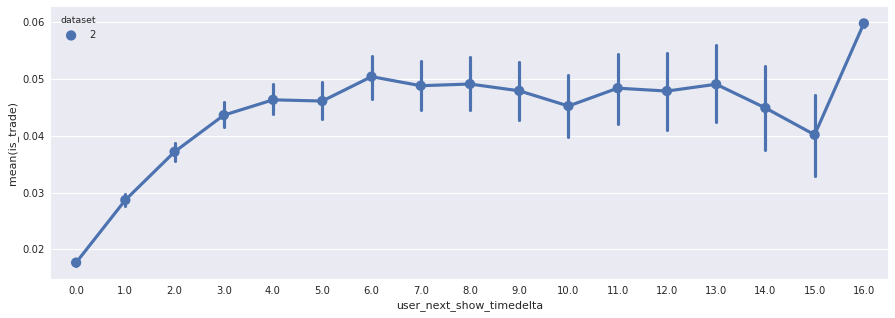

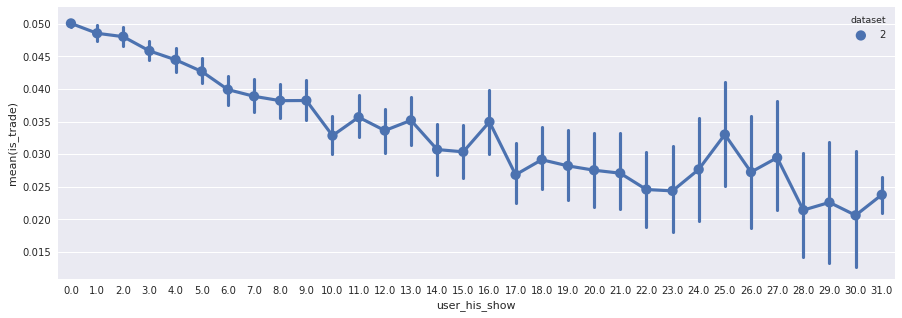

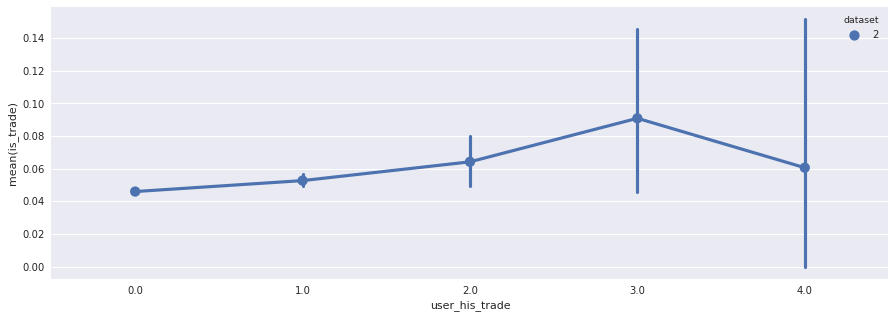

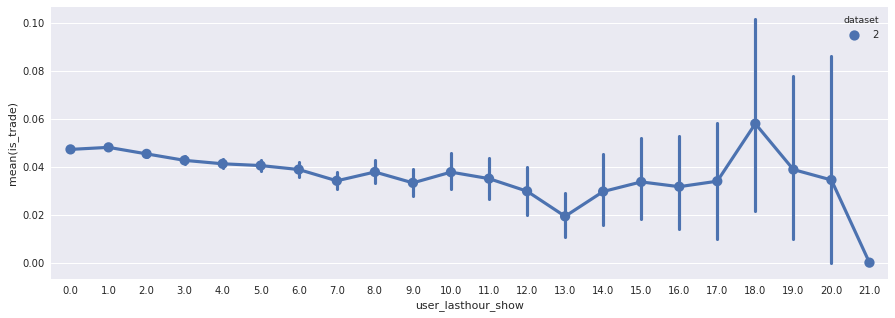

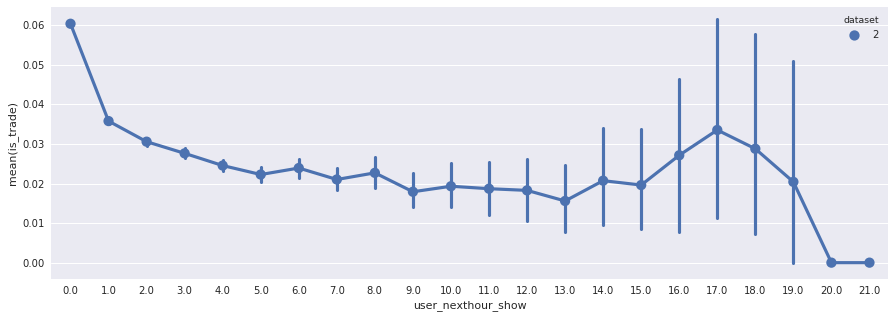

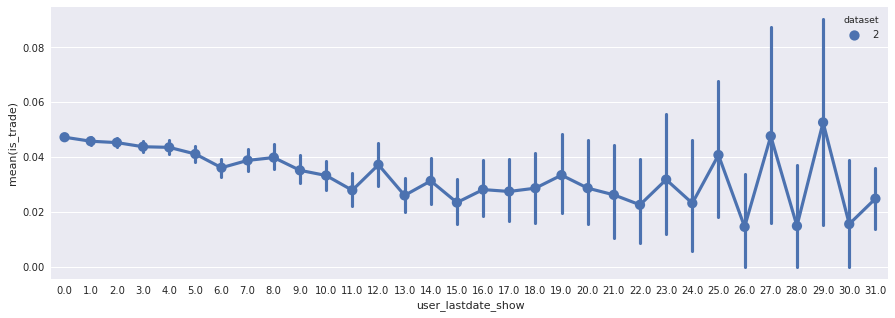

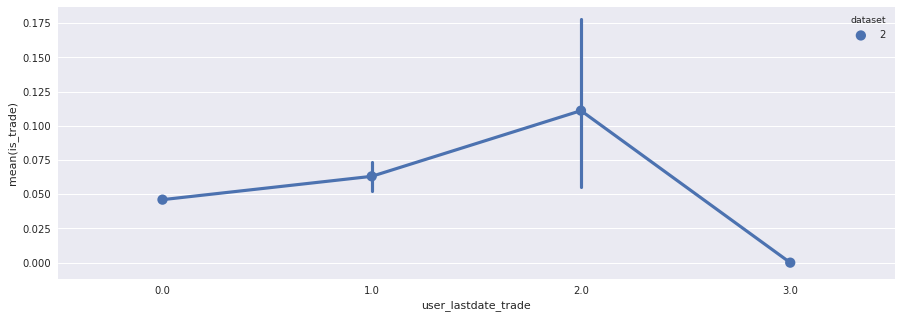

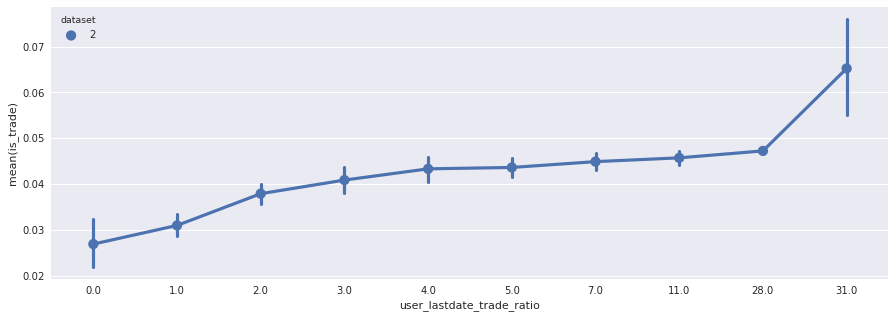

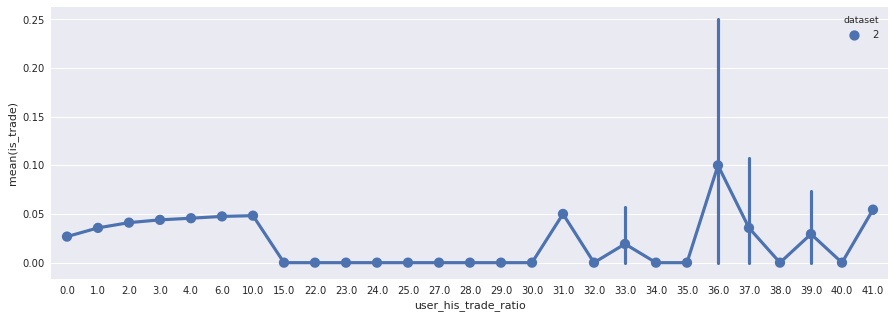

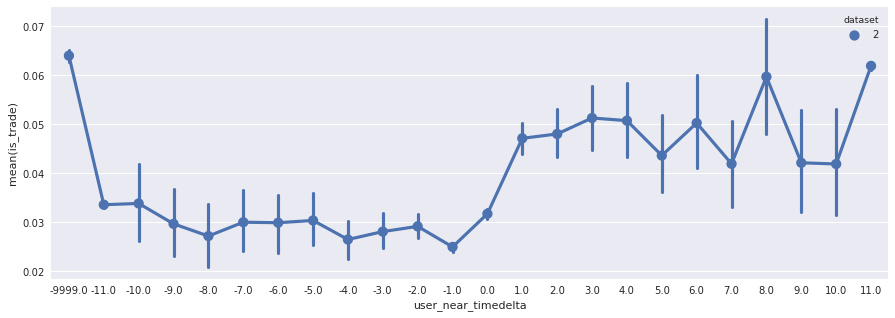

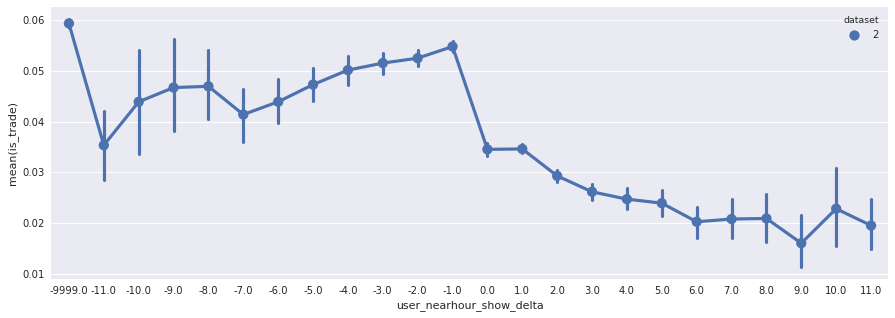

In [54]:
# 用户维度
tempDf = df.copy()
cols = ['user_last_show_timedelta','user_next_show_timedelta','user_his_show','user_his_trade',
        'user_lasthour_show','user_nexthour_show','user_lastdate_show','user_lastdate_trade',
        'user_lastdate_trade_ratio','user_his_trade_ratio','user_near_timedelta','user_nearhour_show_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf.loc[:,['user_last_show_timedelta','user_next_show_timedelta']] = tempDf.loc[:,['user_last_show_timedelta','user_next_show_timedelta']] // 100
tempDf.loc[tempDf.user_last_show_timedelta>15,'user_last_show_timedelta'] = 16
tempDf.loc[tempDf.user_next_show_timedelta>15,'user_next_show_timedelta'] = 16
tempDf.loc[tempDf.user_his_show>30,'user_his_show'] = 31
tempDf.loc[tempDf.user_lasthour_show>20,'user_lasthour_show'] = 21
tempDf.loc[tempDf.user_nexthour_show>20,'user_nexthour_show'] = 21
tempDf.loc[tempDf.user_lastdate_show>30,'user_lastdate_show'] = 31
tempDf['user_lastdate_trade_ratio'] = tempDf['user_lastdate_trade_ratio'] // 0.0002
tempDf.loc[tempDf.user_lastdate_trade_ratio>30,'user_lastdate_trade_ratio'] = 31 #28往后波动很剧烈
tempDf['user_his_trade_ratio'] = tempDf['user_his_trade_ratio'] // 0.0005
tempDf.loc[tempDf.user_his_trade_ratio>40,'user_his_trade_ratio'] = 41 #31前后波动剧烈
tempDf['user_near_timedelta'] = tempDf['user_near_timedelta'] // 600
tempDf.loc[tempDf.user_near_timedelta<-10,'user_near_timedelta'] = -11
tempDf.loc[tempDf.user_near_timedelta>10,'user_near_timedelta'] = 11
# tempDf.loc[tempDf.user_near_timedelta.isnull(),'user_near_timedelta'] = 9999
tempDf.loc[tempDf.user_nearhour_show_delta>10,'user_nearhour_show_delta'] = 11
tempDf.loc[tempDf.user_nearhour_show_delta<-10,'user_nearhour_show_delta'] = -11
# tempDf.loc[tempDf.user_nearhour_show_delta.isnull(),'user_nearhour_show_delta'] = 9999
printSingleFeaLine(tempDf, cols)

                            pearsonr      p_values
cate_his_trade_ratio       0.0826206             0
cate2_his_trade_ratio       0.102575             0
cate_lastdate_show        -0.0030133    0.00176352
cate_lastdate_trade        0.0646349             0
cate_lastdate_trade_ratio  0.0763635             0
cate_age_delta             0.0278037  8.67951e-183
cate_sales_mean            0.0795766             0
5.0     218880
12.0    151607
6.0      91497
4.0      89976
19.0     86622
17.0     85277
7.0      77884
9.0      71726
32.0     48635
10.0     40324
3.0      34408
13.0     26206
2.0      16847
26.0     11656
23.0      8167
15.0      6789
8.0       6345
24.0      1936
35.0      1929
22.0       464
Name: cate_his_trade_ratio, dtype: int64
4999.0     218880
11999.0    151607
5999.0      91497
3999.0      89976
18999.0     86622
16999.0     85277
6999.0      77884
8999.0      71726
31999.0     48635
9999.0      40324
2999.0      34408
12999.0     26206
1999.0      16847
25999.0     11656

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


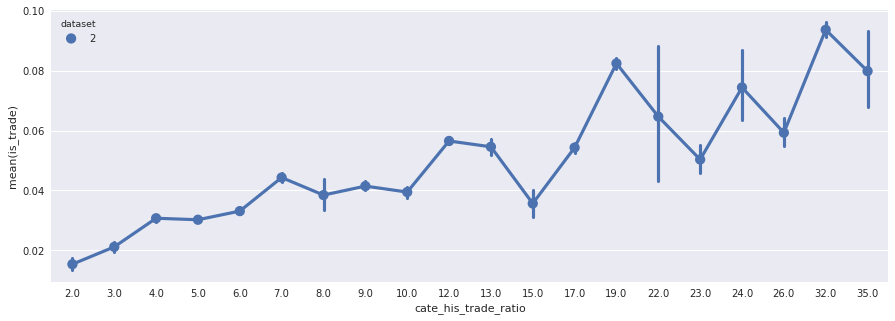

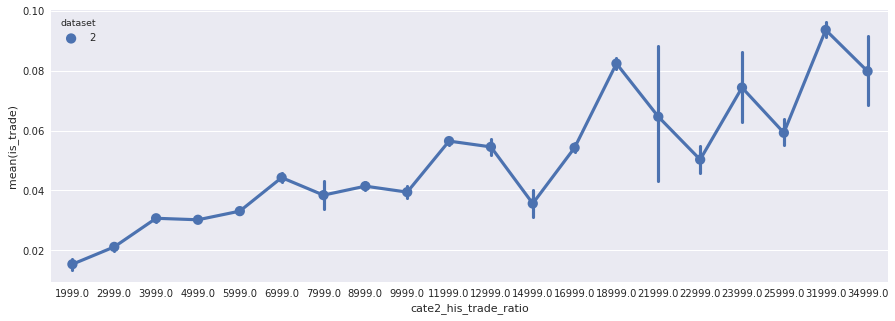

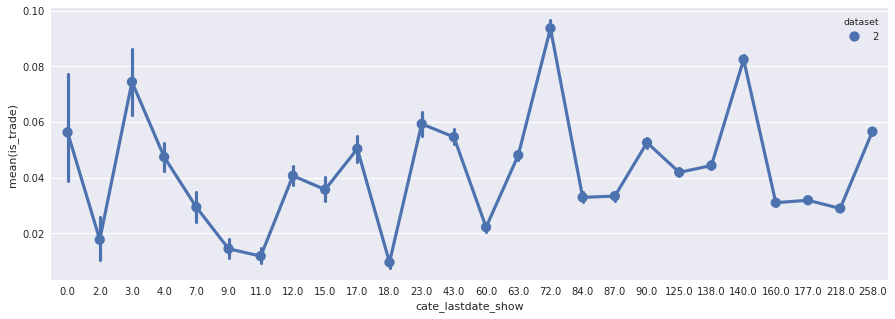

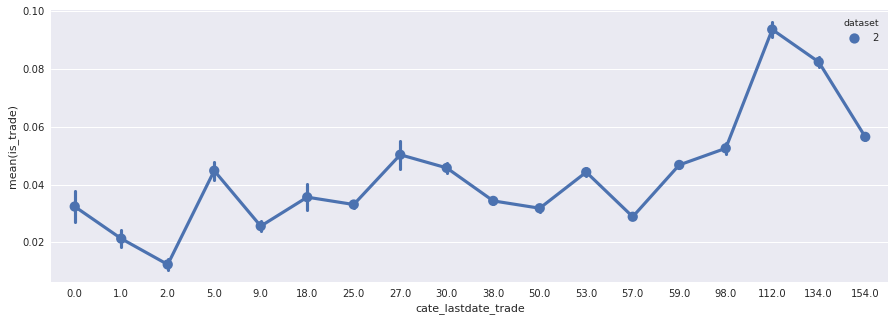

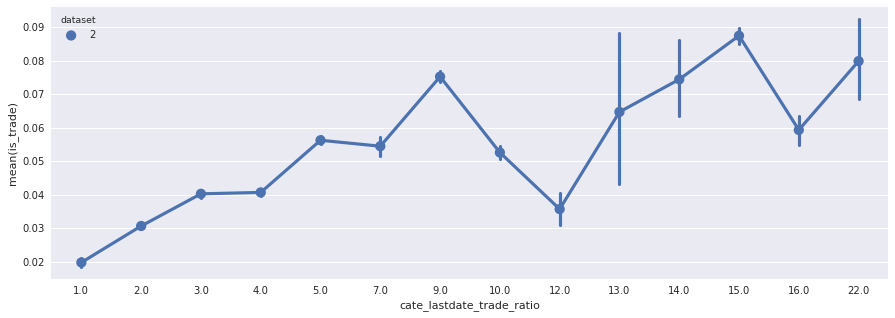

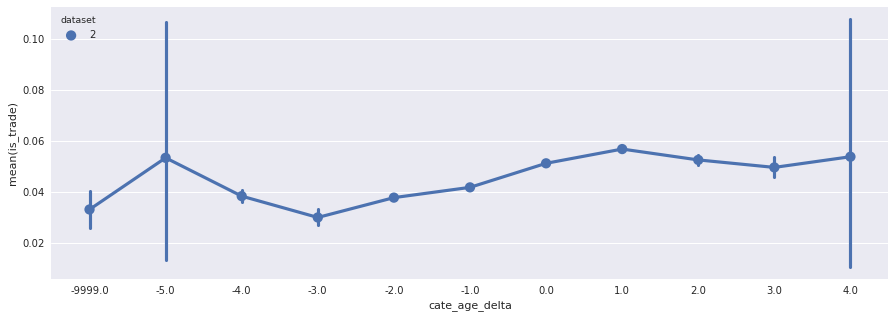

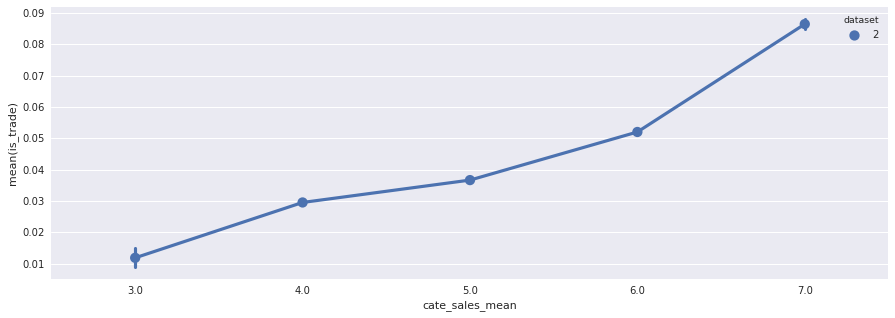

In [61]:
# 类别维度
tempDf = df.copy()
cols = ['cate_his_trade_ratio','cate2_his_trade_ratio','cate_lastdate_show','cate_lastdate_trade','cate_lastdate_trade_ratio',
        'cate_age_delta','cate_sales_mean',]
print(getFeaPearsonr(tempDf, cols))
tempDf['cate_his_trade_ratio'] = tempDf['cate_his_trade_ratio'] // 0.001
tempDf['cate2_his_trade_ratio'] = tempDf['cate_his_trade_ratio'] // 0.001
tempDf['cate_lastdate_show'] = tempDf['cate_lastdate_show'] // 1000
# tempDf.loc[tempDf.cate_lastdate_show<4,'cate_lastdate_show'] = 3
tempDf['cate_lastdate_trade'] = tempDf['cate_lastdate_trade'] // 10
tempDf['cate_lastdate_trade_ratio'] = tempDf['cate_lastdate_trade_ratio'] // 0.001
tempDf['cate_age_delta'] = tempDf['cate_age_delta'] // 1
# tempDf.loc[tempDf.cate_age_delta<-4,'cate_age_delta'] = -4
# tempDf.loc[tempDf.cate_age_delta>3,'cate_age_delta'] = 3
tempDf['cate_sales_mean'] = tempDf['cate_sales_mean'] // 1
# tempDf.loc[tempDf.cate_sales_mean<7,'cate_sales_mean'] = 7
printSingleFeaLine(tempDf, cols)

                                   pearsonr      p_values
item_his_trade_ratio              0.0985005             0
item_prop_num                       0.05683             0
item_his_show                     0.0103726   4.99888e-27
item_his_trade                    0.0693315             0
item_lastdate_show                 0.002472     0.0111814
item_lastdate_trade               0.0656068             0
item_lastdate_trade_ratio         0.0605046             0
item_lastdate_show_delta         0.00291469    0.00277791
item_lastdate_trade_delta         0.0633426             0
item_lastdate_trade_ratio_delta   0.0403859             0
item_sales_delta                  0.0669143             0
item_collected_delta              0.0422936             0
item_price_delta                 0.00199094     0.0387964
item_pv_delta                     0.0253083  4.12334e-152
item_age_delta                    0.0178135   3.61286e-76
0.0     273228
31.0     83879
1.0      78154
3.0      63572
2.0      558

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


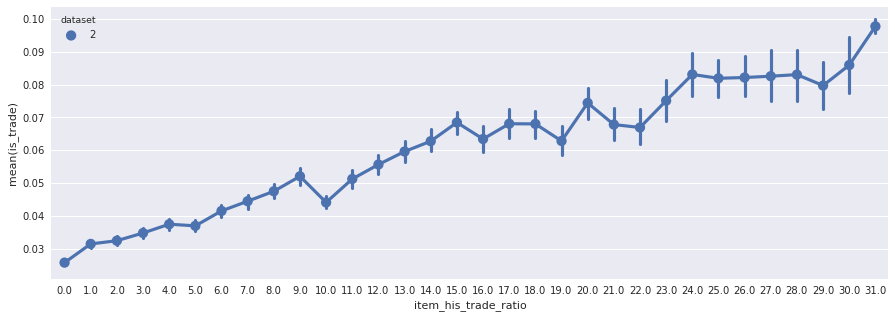

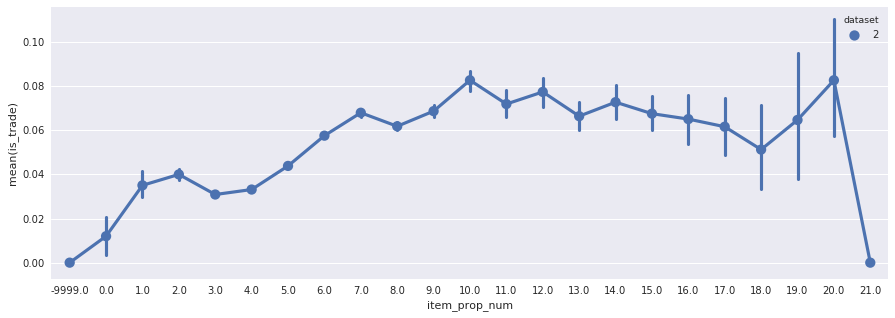

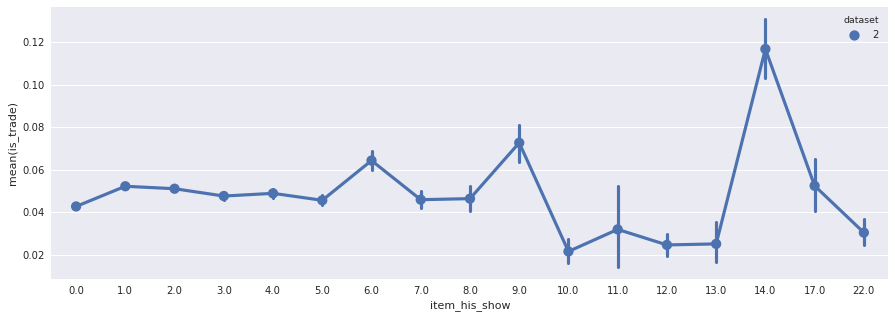

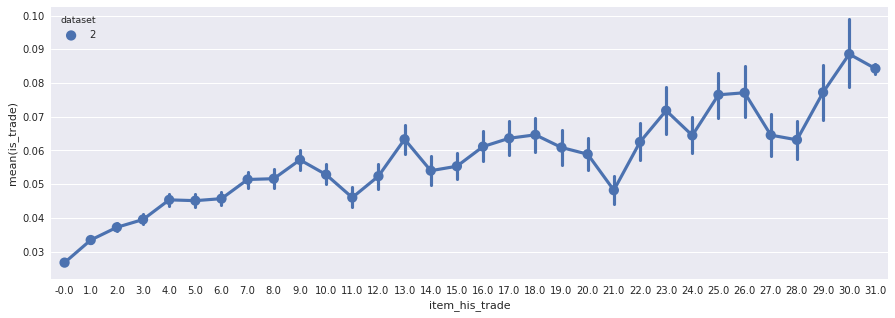

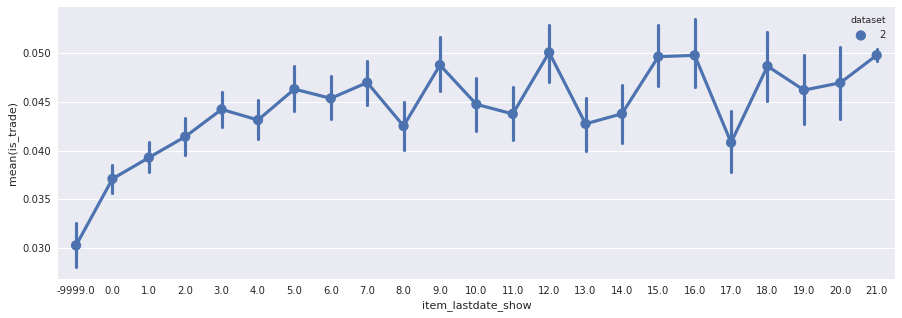

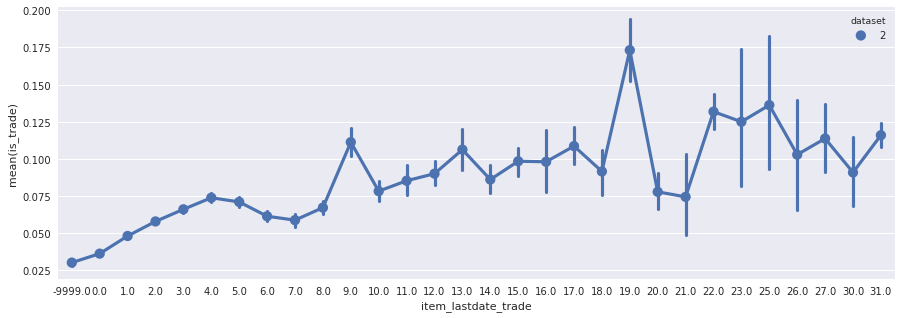

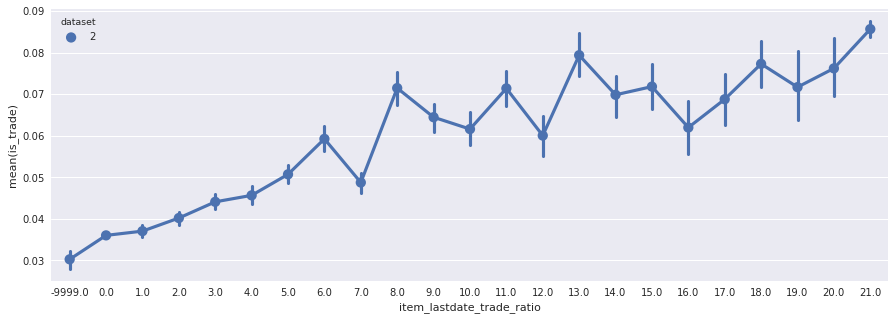

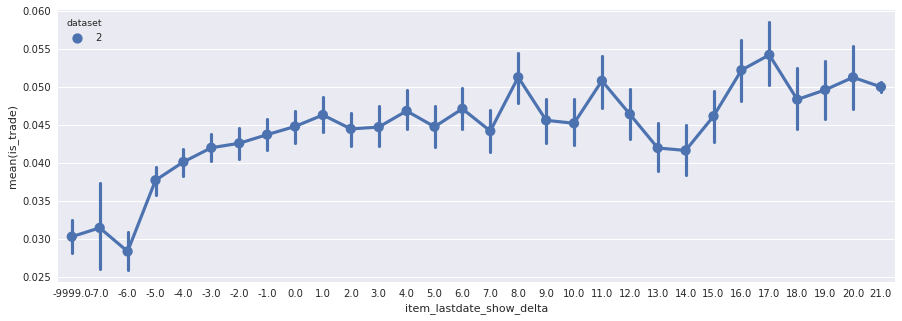

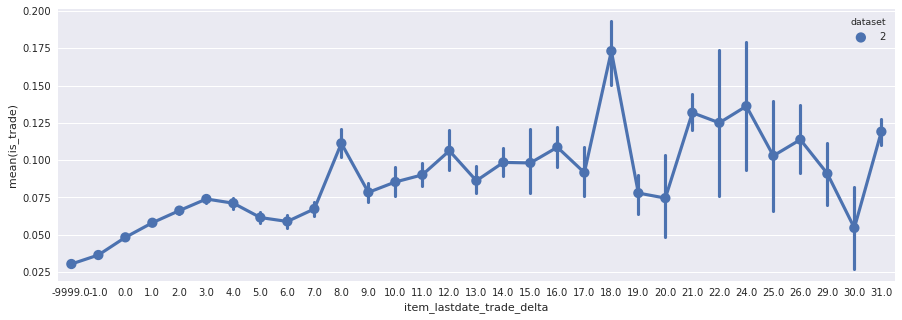

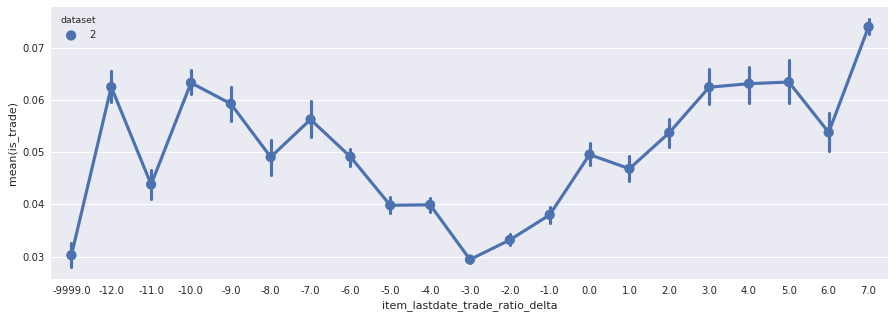

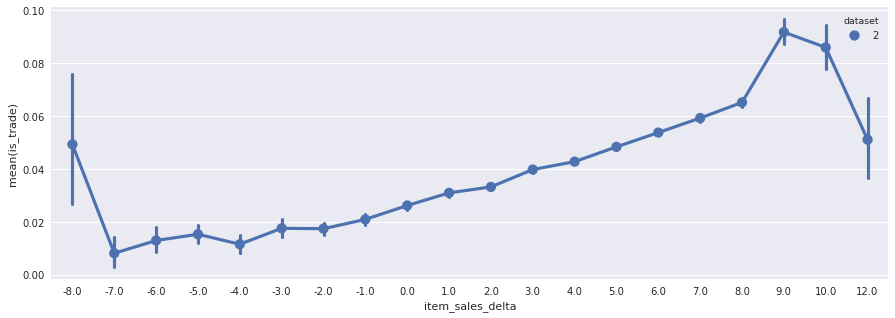

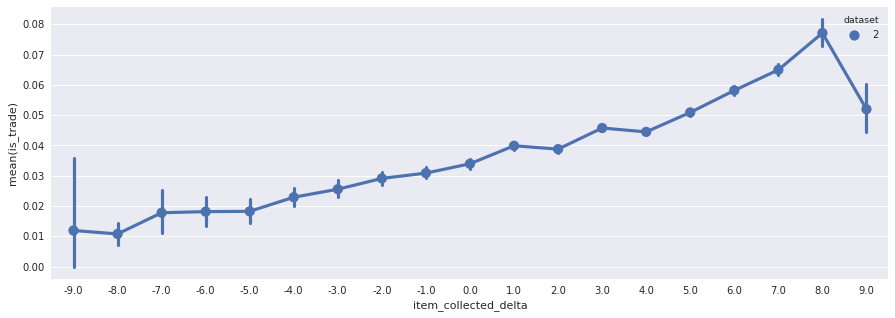

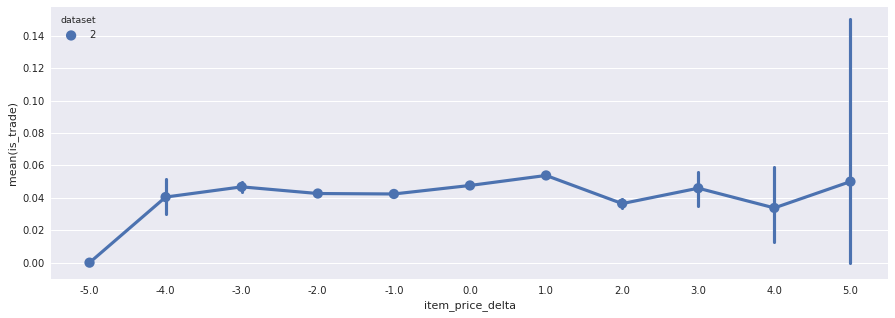

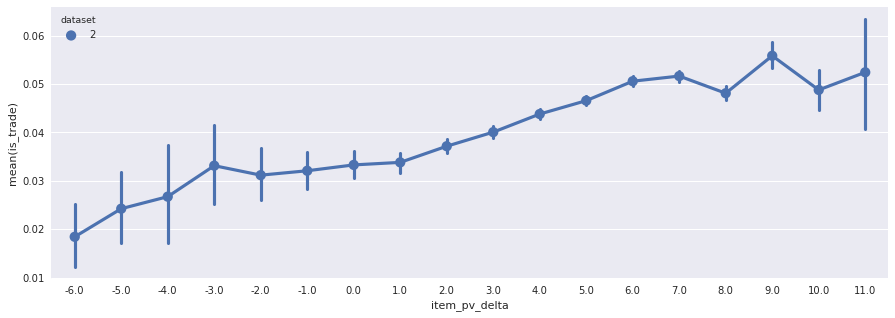

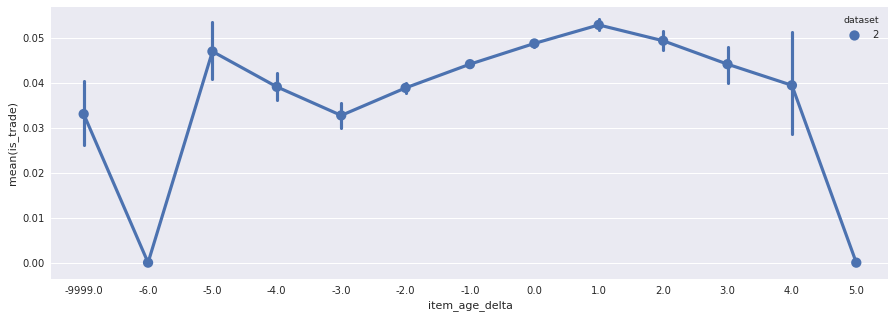

In [63]:
# 商品统计特征
tempDf = df.copy()
cols = ['item_his_trade_ratio','item_prop_num','item_his_show','item_his_trade','item_lastdate_show','item_lastdate_trade','item_lastdate_trade_ratio']
cols += ['item_lastdate_show_delta','item_lastdate_trade_delta','item_lastdate_trade_ratio_delta']
cols += ['item_sales_delta','item_collected_delta','item_price_delta','item_pv_delta']
cols += ['item_age_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf['item_his_trade_ratio'] = tempDf['item_his_trade_ratio'] // 0.001
tempDf.loc[tempDf.item_his_trade_ratio>30,'item_his_trade_ratio'] = 31
tempDf['item_prop_num'] = tempDf['item_prop_num'] // 5
# tempDf.loc[tempDf.item_prop_num<1,'item_prop_num'] = 1
# tempDf.loc[tempDf.item_prop_num>15,'item_prop_num'] = 16
tempDf['item_his_show'] = tempDf['item_his_show'] // 1000
# tempDf.loc[tempDf.item_his_show>20,'item_his_show'] = 21
tempDf['item_his_trade'] = tempDf['item_his_trade'] // 1
tempDf.loc[tempDf.item_his_trade>30,'item_his_trade'] = 31
tempDf['item_lastdate_show'] = tempDf['item_lastdate_show'] // 10
tempDf.loc[tempDf.item_lastdate_show>20,'item_lastdate_show'] = 21
tempDf.loc[tempDf.item_lastdate_trade>30,'item_lastdate_trade'] = 31
tempDf['item_lastdate_trade_ratio'] = tempDf['item_lastdate_trade_ratio'] // 0.001
tempDf.loc[tempDf.item_lastdate_trade_ratio>20,'item_lastdate_trade_ratio'] = 21

tempDf['item_lastdate_show_delta'] = tempDf['item_lastdate_show_delta'] // 10
tempDf.loc[tempDf.item_lastdate_show_delta>20,'item_lastdate_show_delta'] = 21
tempDf['item_lastdate_trade_delta'] = tempDf['item_lastdate_trade_delta'] // 1
tempDf.loc[tempDf.item_lastdate_trade_delta>30,'item_lastdate_trade_delta'] = 31
tempDf['item_lastdate_trade_ratio_delta'] = tempDf['item_lastdate_trade_ratio_delta'] // 0.001
tempDf.loc[tempDf.item_lastdate_trade_ratio_delta>6,'item_lastdate_trade_ratio_delta'] = 7
tempDf.loc[tempDf.item_lastdate_trade_ratio_delta<-11,'item_lastdate_trade_ratio_delta'] = -12

tempDf['item_sales_delta'] = tempDf['item_sales_delta'] // 1
# tempDf.loc[tempDf.item_sales_delta<-6,'item_sales_delta'] = -6
# tempDf.loc[tempDf.item_sales_delta>10,'item_sales_delta'] = 10
tempDf['item_collected_delta'] = tempDf['item_collected_delta'] // 1
# tempDf.loc[tempDf.item_collected_delta>8,'item_collected_delta'] = 8
# tempDf.loc[tempDf.item_collected_delta<-8,'item_collected_delta'] = -8
tempDf['item_price_delta'] = tempDf['item_price_delta'] // 1
# tempDf.loc[tempDf.item_price_delta<-3,'item_price_delta'] = -3
# tempDf.loc[tempDf.item_price_delta>2,'item_price_delta'] = 2
tempDf['item_pv_delta'] = tempDf['item_pv_delta'] // 1
# tempDf.loc[tempDf.item_pv_delta<-3,'item_pv_delta'] = -4
tempDf['item_age_delta'] = tempDf['item_age_delta'] // 1
# tempDf.loc[tempDf.item_age_delta>3,'item_age_delta'] = 3
# tempDf.loc[tempDf.item_age_delta<-3,'item_age_delta'] = -3
printSingleFeaLine(tempDf, cols)

                                 pearsonr      p_values
shop_his_trade_ratio            0.0959103             0
shop_lastdate_show             -0.0248559  2.36294e-145
shop_lastdate_trade             0.0590733             0
shop_lastdate_trade_ratio       0.0640209             0
shop_lastdate_show_delta       -0.0247741  2.06488e-144
shop_age_delta                  0.0194482   1.98275e-90
shop_gender_ratio_delta        -0.0137948   1.69224e-46
shop_gender_ratio             -0.00506621   1.45557e-07
shop_sales_delta                0.0588671             0
shop_collected_delta            0.0412579             0
shop_price_delta                0.0110162   2.83556e-30
shop_pv_delta                    0.042957             0
shop_item_count                -0.0257938  6.31104e-158
shop_score_service_delta       -0.0225429  4.56664e-121
shop_score_delivery_delta      -0.0265409  4.67721e-167
shop_score_description_delta  -0.00381071   7.66545e-05
shop_review_positive_delta     0.00522412   5.89

 3.0     174164
 4.0     141390
 2.0     141297
 1.0     133650
 0.0      89928
 5.0      74871
 6.0      64203
-1.0      58280
 7.0      57213
-2.0      42561
-3.0      27427
-4.0      15998
 8.0      13565
 9.0      11612
-5.0       9307
-6.0       7359
-8.0       4648
-7.0       4483
-9.0       2874
 10.0      1575
-10.0       744
-11.0        26
Name: shop_star_level_delta, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


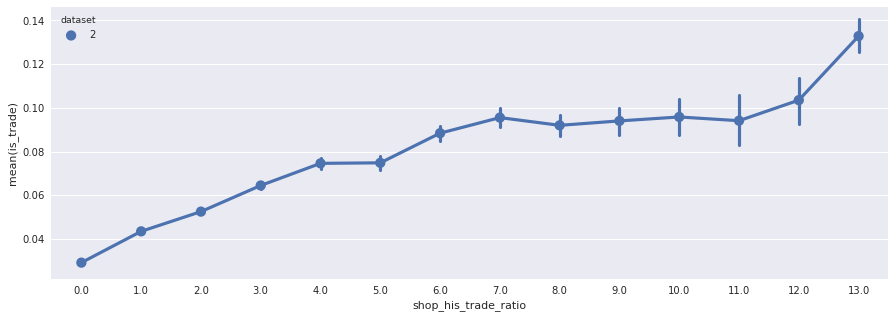

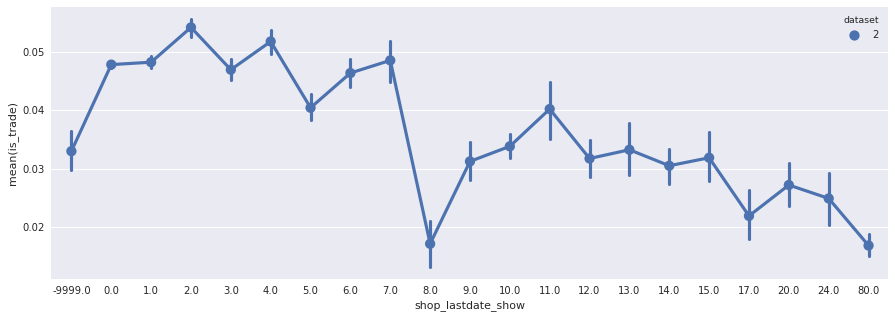

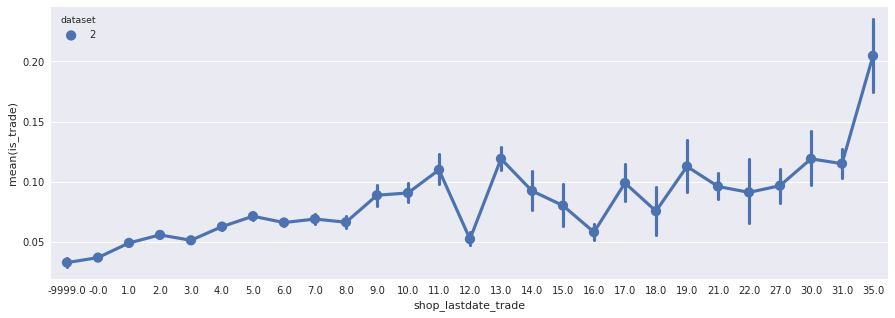

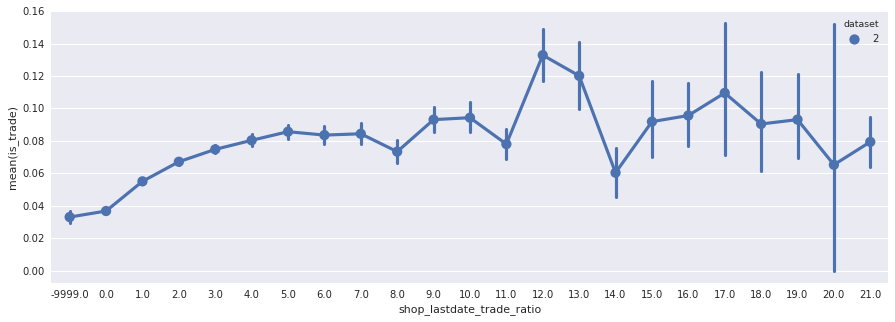

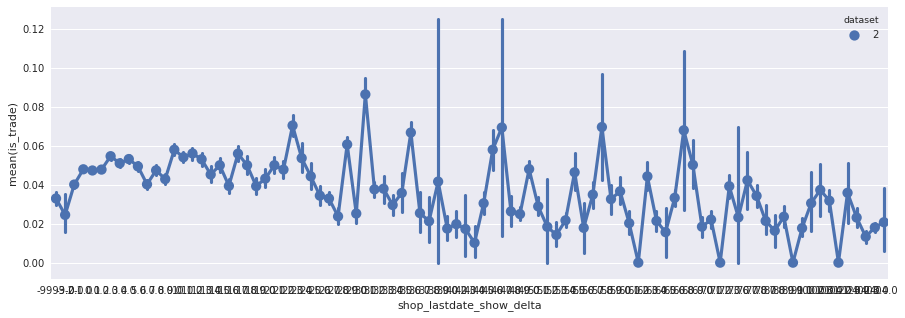

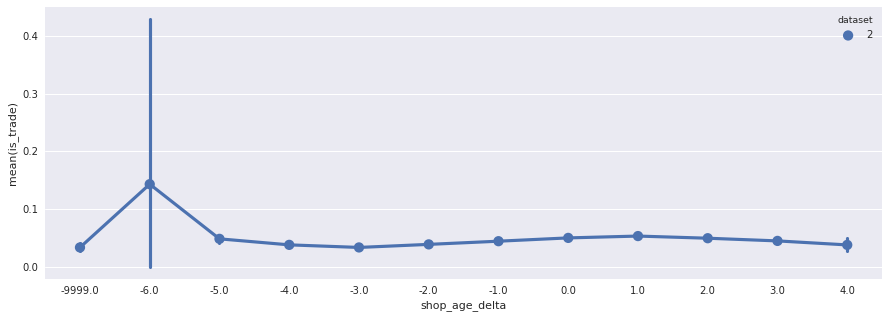

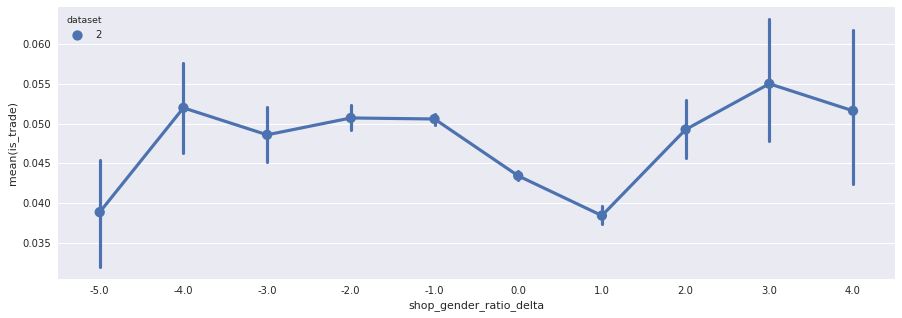

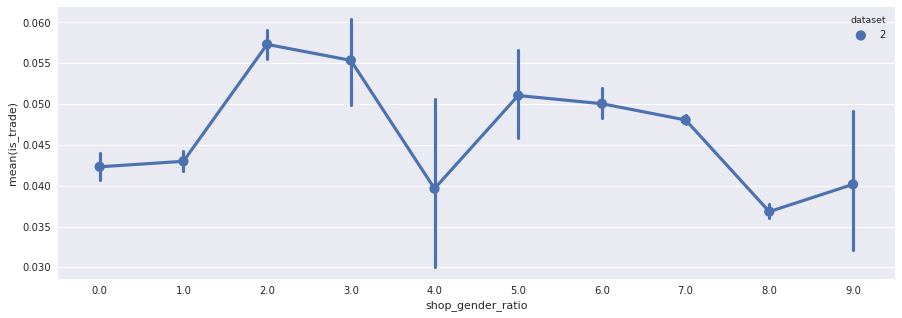

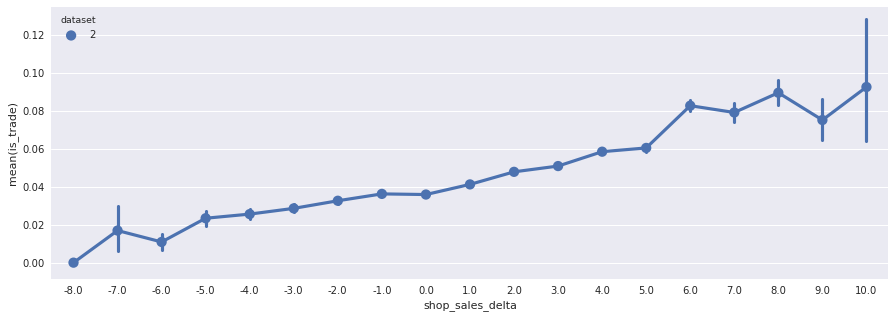

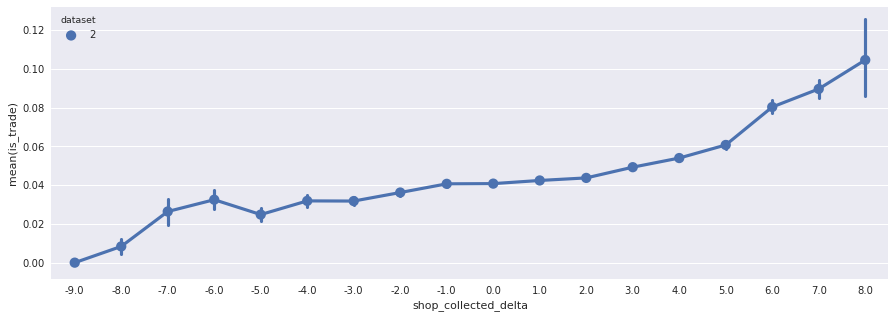

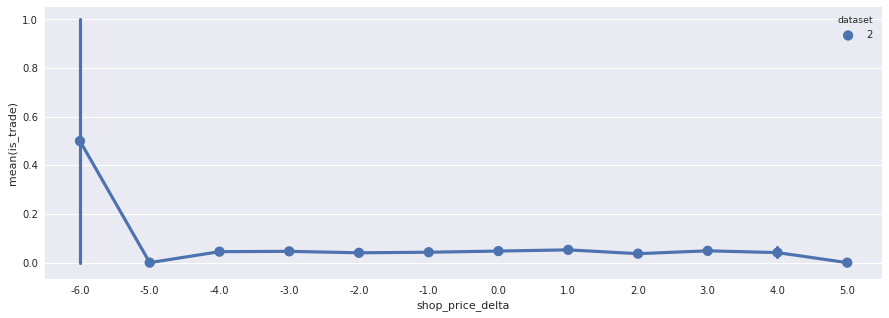

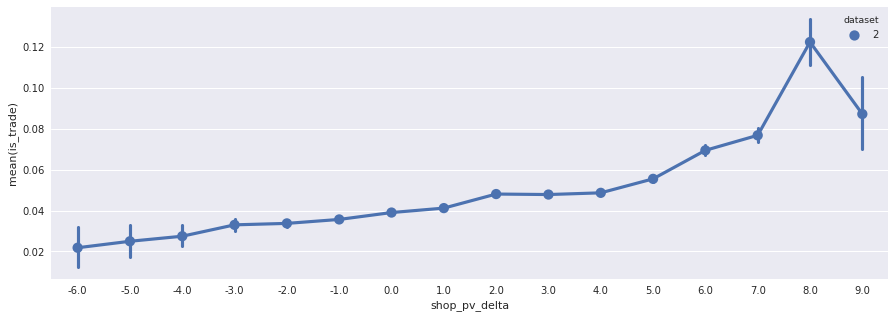

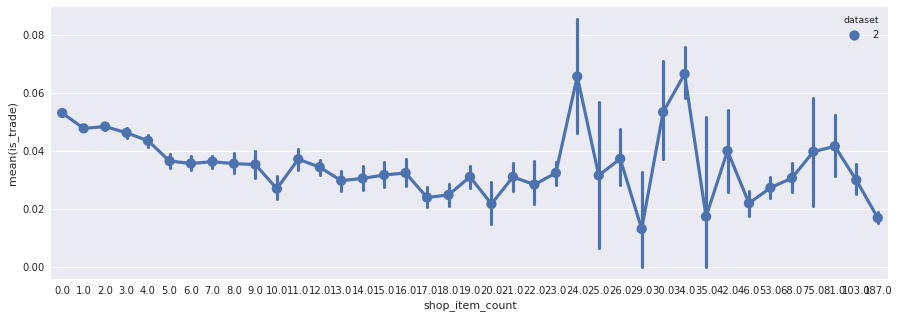

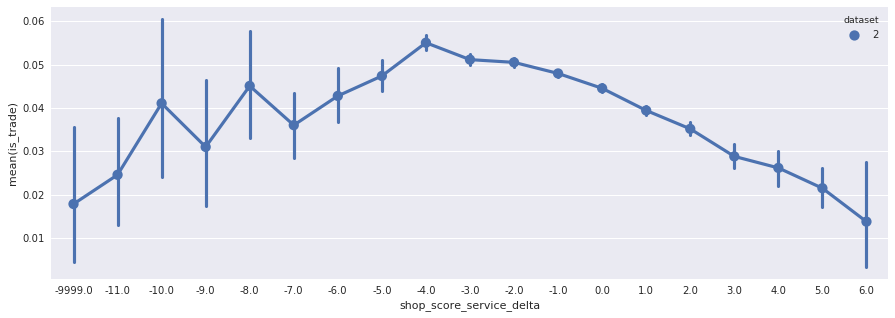

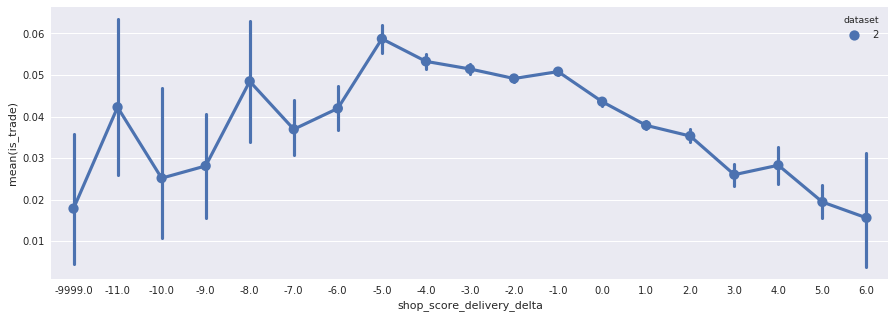

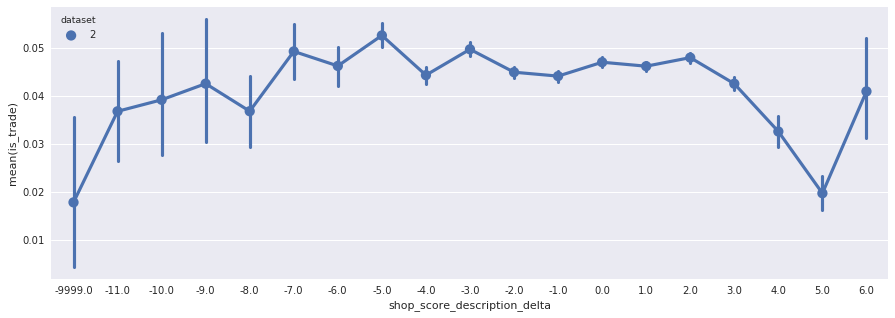

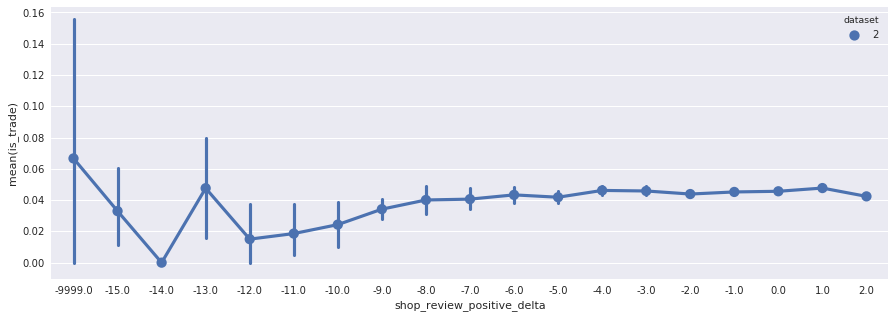

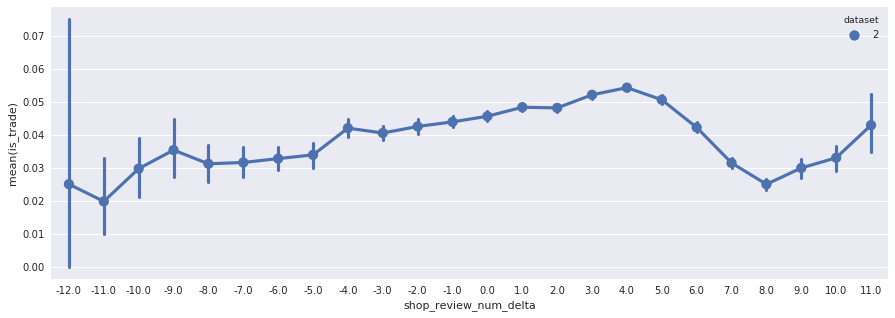

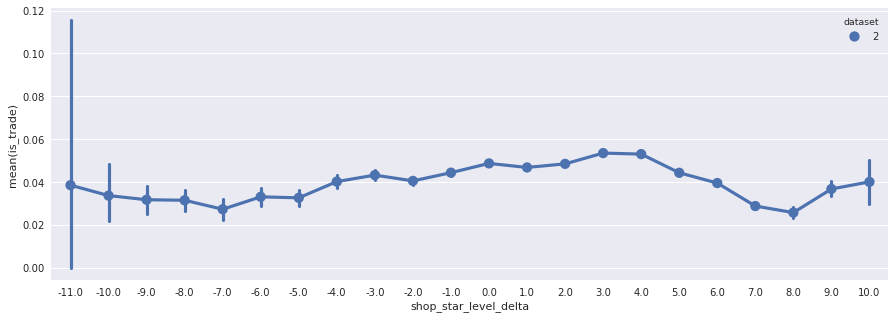

In [104]:
# 店铺统计特征
tempDf = df.copy()
cols = ['shop_his_trade_ratio','shop_lastdate_show','shop_lastdate_trade','shop_lastdate_trade_ratio','shop_lastdate_show_delta']
cols += ['shop_age_delta','shop_gender_ratio_delta','shop_gender_ratio']
cols += ['shop_sales_delta','shop_collected_delta','shop_price_delta','shop_pv_delta','shop_item_count']
cols += ['shop_score_service_delta','shop_score_delivery_delta','shop_score_description_delta','shop_review_positive_delta','shop_review_num_delta','shop_star_level_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf['shop_his_trade_ratio'] = tempDf['shop_his_trade_ratio'] // 0.005
tempDf.loc[tempDf.shop_his_trade_ratio>12,'shop_his_trade_ratio'] = 13
tempDf['shop_lastdate_show'] = tempDf['shop_lastdate_show'] // 500
# tempDf.loc[tempDf.shop_lastdate_show>10,'shop_lastdate_show'] = 11
tempDf['shop_lastdate_trade'] = tempDf['shop_lastdate_trade'] // 2
# tempDf.loc[tempDf.shop_lastdate_trade>8,'shop_lastdate_trade'] = 9
# tempDf['shop_lastdate_trade'].fillna(-1, inplace=True)
tempDf['shop_lastdate_trade_ratio'] = tempDf['shop_lastdate_trade_ratio'] // 0.005
tempDf.loc[tempDf.shop_lastdate_trade_ratio>20,'shop_lastdate_trade_ratio'] = 21
# tempDf['shop_lastdate_trade_ratio'].fillna(-1, inplace=True)
tempDf['shop_lastdate_show_delta'] = tempDf['shop_lastdate_show_delta'] // 100
# tempDf.loc[tempDf.shop_lastdate_show_delta>7,'shop_lastdate_show_delta'] = 8
# tempDf.loc[tempDf.shop_lastdate_show_delta<-3,'shop_lastdate_show_delta'] = -3

tempDf['shop_age_delta'] = tempDf['shop_age_delta'] // 1
# tempDf.loc[tempDf.shop_age_delta>3,'shop_age_delta'] = 3
# tempDf.loc[tempDf.shop_age_delta<-2,'shop_age_delta'] = -3
tempDf['shop_gender_ratio_delta'] = tempDf['shop_gender_ratio_delta'] // 0.05
tempDf.loc[tempDf.shop_gender_ratio_delta>3,'shop_gender_ratio_delta'] = 4
tempDf.loc[tempDf.shop_gender_ratio_delta<-4,'shop_gender_ratio_delta'] = -5
tempDf['shop_gender_ratio'] = tempDf['shop_gender_ratio'] // 0.1

tempDf['shop_sales_delta'] = tempDf['shop_sales_delta'] // 1
# tempDf.loc[tempDf.shop_sales_delta>6,'shop_sales_delta'] = 7
# tempDf.loc[tempDf.shop_sales_delta<-6,'shop_sales_delta'] = -6
tempDf['shop_collected_delta'] = tempDf['shop_collected_delta'] // 1
# tempDf.loc[tempDf.shop_collected_delta>6,'shop_collected_delta'] = 7
# tempDf.loc[tempDf.shop_collected_delta<-5,'shop_collected_delta'] = -6
tempDf['shop_price_delta'] = tempDf['shop_price_delta'] // 1
# tempDf.loc[tempDf.shop_price_delta>4,'shop_price_delta'] = 4
# tempDf.loc[tempDf.shop_price_delta<-3,'shop_price_delta'] = -3
tempDf['shop_pv_delta'] = tempDf['shop_pv_delta'] // 1
# tempDf.loc[tempDf.shop_pv_delta>6,'shop_pv_delta'] = 7
# tempDf.loc[tempDf.shop_pv_delta<-4,'shop_pv_delta'] = -5
tempDf['shop_item_count'] = tempDf['shop_item_count'] // 5
# tempDf.loc[tempDf.shop_item_count>7,'shop_item_count'] = 8

tempDf['shop_score_service_delta'] = tempDf['shop_score_service_delta'] // 0.005
tempDf.loc[tempDf.shop_score_service_delta>5,'shop_score_service_delta'] = 6
tempDf.loc[tempDf.shop_score_service_delta<-10,'shop_score_service_delta'] = -11
tempDf['shop_score_delivery_delta'] = tempDf['shop_score_delivery_delta'] // 0.005
tempDf.loc[tempDf.shop_score_delivery_delta>5,'shop_score_delivery_delta'] = 6
tempDf.loc[tempDf.shop_score_delivery_delta<-10,'shop_score_delivery_delta'] = -11
tempDf['shop_score_description_delta'] = tempDf['shop_score_description_delta'] // 0.005
tempDf.loc[tempDf.shop_score_description_delta>5,'shop_score_description_delta'] = 6
tempDf.loc[tempDf.shop_score_description_delta<-10,'shop_score_description_delta'] = -11
tempDf['shop_review_positive_delta'] = tempDf['shop_review_positive_delta'] // 0.005
tempDf.loc[tempDf.shop_review_positive_delta<-14,'shop_review_positive_delta'] = -15
tempDf['shop_review_num_delta'] = tempDf['shop_review_num_delta'] // 1
# tempDf.loc[tempDf.shop_review_num_delta>4,'shop_review_num_delta'] = 4
# tempDf.loc[tempDf.shop_review_num_delta<-3,'shop_review_num_delta'] = -3
tempDf['shop_star_level_delta'] = tempDf['shop_star_level_delta'] // 1
# tempDf.loc[tempDf.shop_star_level_delta>3,'shop_star_level_delta'] = 3
# tempDf.loc[tempDf.shop_star_level_delta<-2,'shop_star_level_delta'] = -2

printSingleFeaLine(tempDf, cols)

                       pearsonr      p_values
shop_item_count_delta -0.025538  7.55281e-155
-2.0     336304
-1.0     254170
 0.0     115048
 21.0     52866
 1.0      50647
 2.0      39673
-3.0      39129
 3.0      24986
 5.0      23901
 4.0      19792
 6.0      17902
 10.0     16826
 9.0      12178
 12.0      9037
 11.0      8029
 16.0      6910
 13.0      6412
 17.0      6251
 15.0      5875
 7.0       5822
 8.0       5502
-4.0       5078
 14.0      4495
 19.0      4470
 20.0      2638
-5.0       1846
 18.0      1388
Name: shop_item_count_delta, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


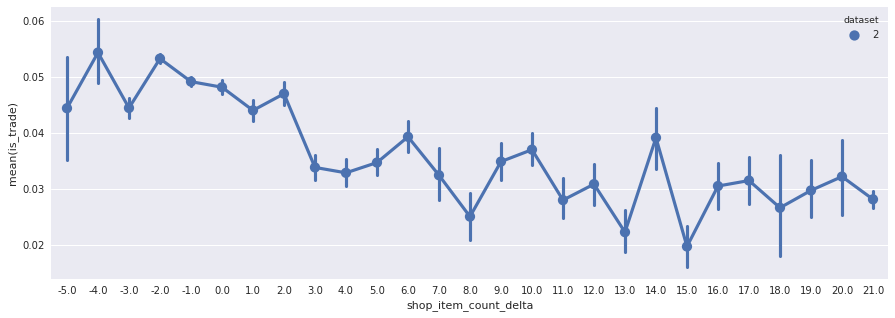

In [112]:
# 店铺统计特征
tempDf = df.copy()
cols = ['shop_item_count_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf['shop_item_count_delta'] = tempDf['shop_item_count_delta'] // 5
tempDf.loc[tempDf.shop_item_count_delta>20, 'shop_item_count_delta'] = 21
printSingleFeaLine(tempDf, cols)

                              pearsonr      p_values
brand_his_trade_ratio        0.0870119             0
brand_item_count           -0.00429962   2.24361e-05
brand_lastdate_trade_ratio   0.0618048             0
brand_collected_delta        0.0217232  8.68469e-102
brand_price_delta            0.0214171   5.41253e-99
brand_pv_delta               0.0283709  3.06433e-172
brand_sales_delta             0.033288  2.28987e-236
brand_age_delta               0.021709  1.81462e-101
shop_brand_item_ratio      -0.00258581    0.00828148
shop_brand_count_ratio       0.0284081  3.09659e-187
shop_brand_special_degree   -0.0328909  2.62733e-250
 13.0      145737
 0.0       131387
-9999.0    104898
 1.0        78657
 3.0        63313
 2.0        61647
 4.0        56888
 7.0        53367
 5.0        44066
 31.0       41002
 6.0        34837
 11.0       34649
 8.0        29440
 9.0        28876
 15.0       25581
 12.0       22997
 10.0       21723
 14.0       14191
 18.0       10529
 21.0        9304
 17.

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


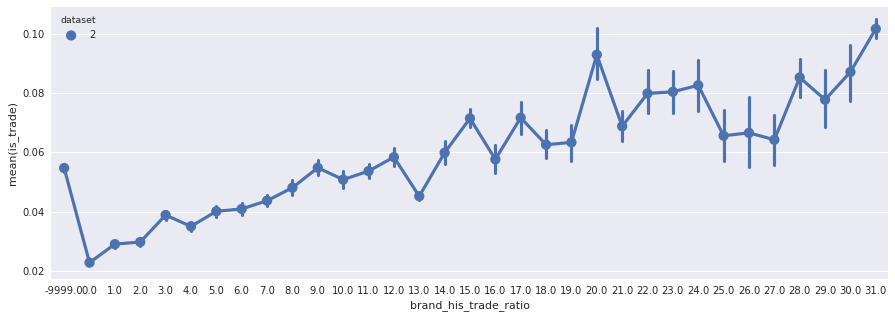

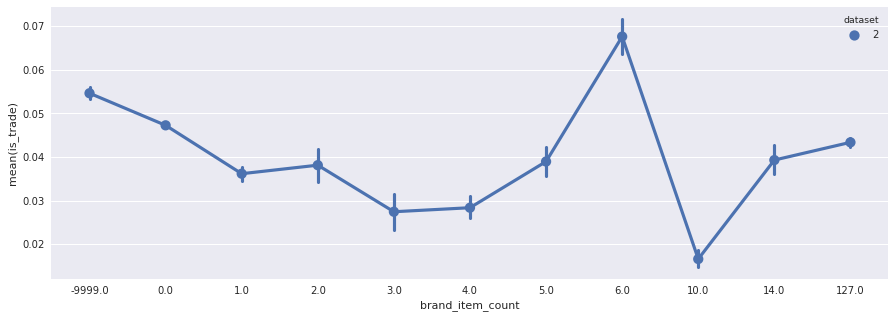

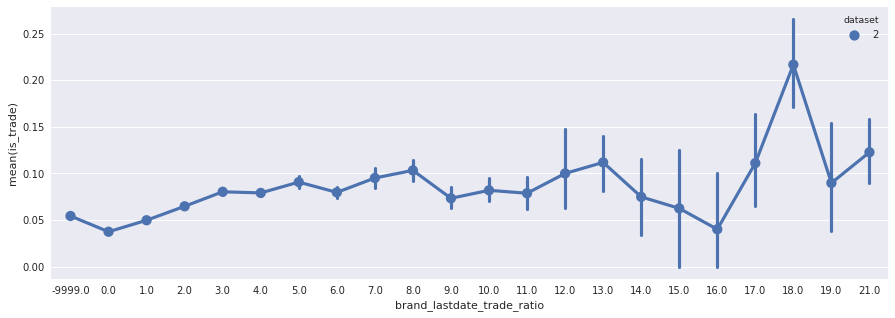

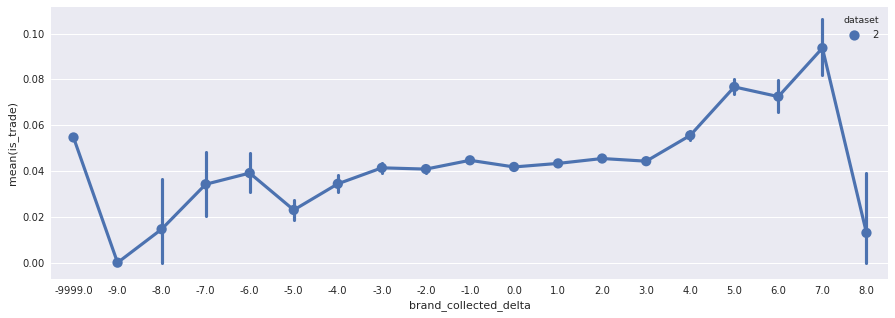

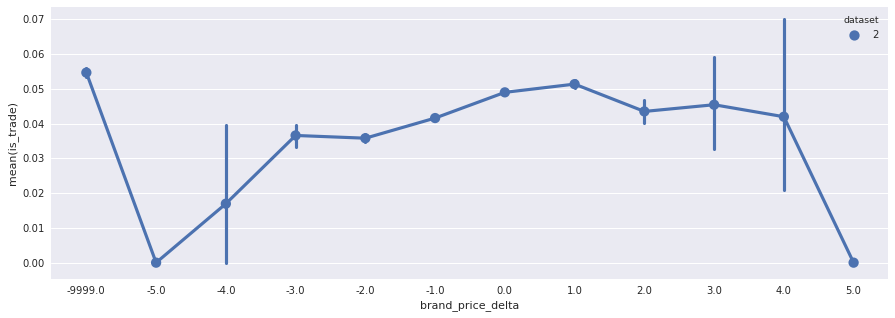

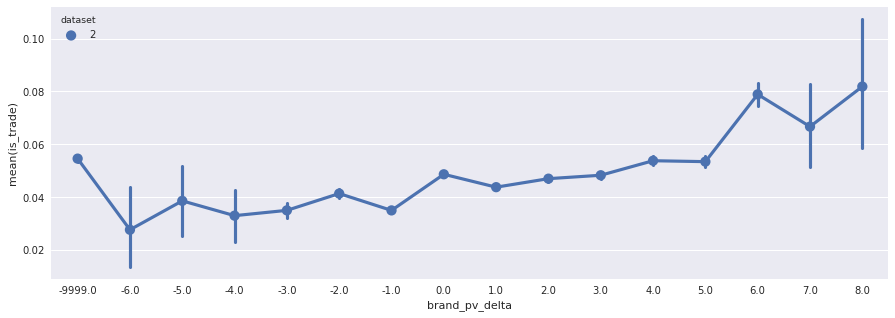

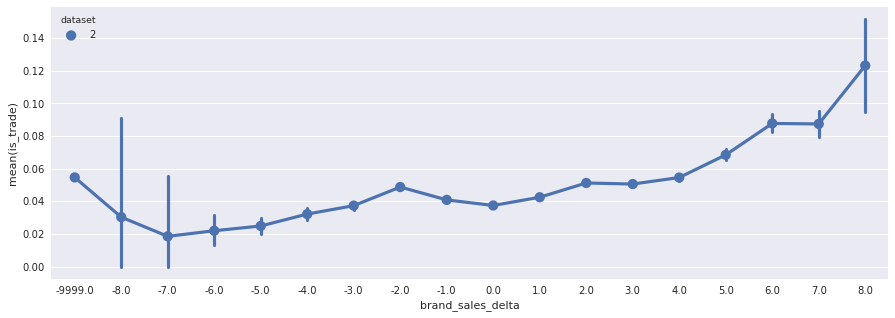

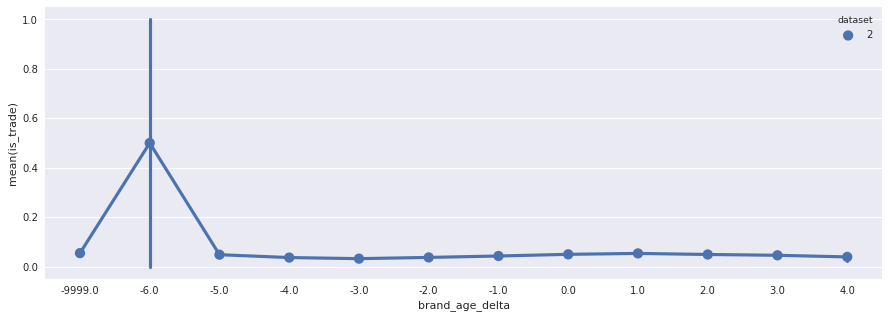

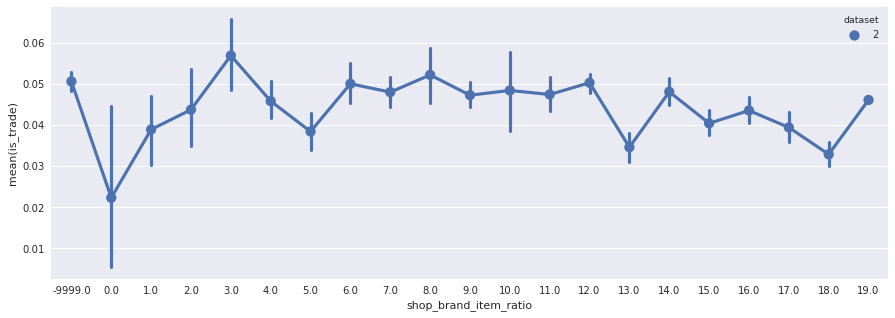

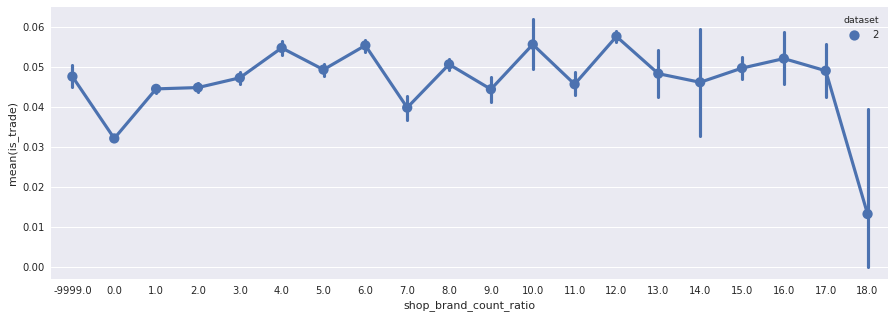

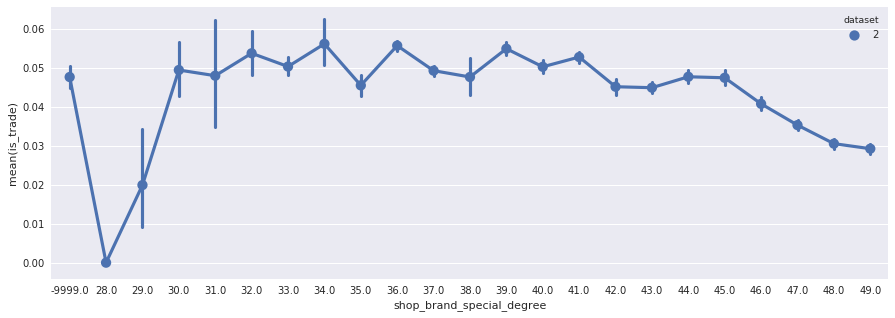

In [139]:
# 品牌统计特征
# 性别比例差值逻辑不合理，后期重测
tempDf = df.copy()
cols = ['brand_his_trade_ratio','brand_item_count','brand_lastdate_trade_ratio',
        'brand_collected_delta','brand_price_delta','brand_pv_delta','brand_sales_delta',
        'brand_age_delta',#'brand_gender_ratio_delta',
        'shop_brand_item_ratio','shop_brand_count_ratio','shop_brand_special_degree']
print(getFeaPearsonr(tempDf, cols))
tempDf['brand_his_trade_ratio'] = tempDf['brand_his_trade_ratio'] // 0.001
tempDf.loc[tempDf.brand_his_trade_ratio>30,'brand_his_trade_ratio'] = 31
tempDf['brand_item_count'] = tempDf['brand_item_count'] // 100
tempDf['brand_lastdate_trade_ratio'] = tempDf['brand_lastdate_trade_ratio'] // 0.005
tempDf.loc[tempDf.brand_lastdate_trade_ratio>20,'brand_lastdate_trade_ratio'] = 21
tempDf['brand_collected_delta'] = tempDf['brand_collected_delta'] // 1
# tempDf.loc[tempDf.brand_collected_delta>6,'brand_collected_delta'] = 6
# tempDf.loc[tempDf.brand_collected_delta<-5,'brand_collected_delta'] = -5
tempDf['brand_price_delta'] = tempDf['brand_price_delta'] // 1
# tempDf.loc[tempDf.brand_price_delta<-2,'brand_price_delta'] = -2
# tempDf.loc[tempDf.brand_price_delta>1,'brand_price_delta'] = 1
tempDf['brand_pv_delta'] = tempDf['brand_pv_delta'] // 1
# tempDf.loc[tempDf.brand_pv_delta<-3,'brand_pv_delta'] = -3
# tempDf.loc[tempDf.brand_pv_delta>6,'brand_pv_delta'] = 6
tempDf['brand_sales_delta'] = tempDf['brand_sales_delta'] // 1
# tempDf.loc[tempDf.brand_sales_delta<-5,'brand_sales_delta'] = -5
# tempDf.loc[tempDf.brand_sales_delta>6,'brand_sales_delta'] = 6
tempDf['brand_age_delta'] = tempDf['brand_age_delta'] // 1
# tempDf.loc[tempDf.brand_age_delta<-3,'brand_age_delta'] = -3
# tempDf.loc[tempDf.brand_age_delta>2,'brand_age_delta'] = 2
tempDf['brand_gender_ratio_delta'] = tempDf['brand_gender_ratio_delta'] // 0.02
tempDf.loc[tempDf.brand_gender_ratio_delta<-4,'brand_gender_ratio_delta'] = -4
tempDf.loc[tempDf.brand_gender_ratio_delta>3,'brand_gender_ratio_delta'] = 3
tempDf['shop_brand_item_ratio'] = tempDf['shop_brand_item_ratio'] // 0.05
tempDf['shop_brand_count_ratio'] = tempDf['shop_brand_count_ratio'] // 0.05
tempDf['shop_brand_special_degree'] = tempDf['shop_brand_special_degree'] // 0.02
# tempDf.loc[tempDf.shop_brand_special_degree<15,'shop_brand_special_degree'] = 15

printSingleFeaLine(tempDf, cols)

                          pearsonr      p_values
uc_his_trade_ratio       0.0076571   1.90797e-15
uc_last_show_timedelta  0.00147347      0.126198
uc_his_show             -0.0131361   2.50994e-42
uc_lasthour_show       -0.00649018   1.62771e-11
uc_lasthour_show_ratio   0.0119389   2.90774e-35
uc_next_show_timedelta   0.0800722             0
uc_nexthour_show        -0.0608542             0
uc_near_timedelta        0.0815587             0
uc_nearhour_show_delta  -0.0607307             0
uc_price_mean            -0.030403  1.20022e-106
uc_price_delta          -0.0100118   5.12971e-13
138.0    838182
31.0      87138
17.0      49721
12.0      30830
9.0       19872
7.0       13300
6.0        8935
4.0        7892
3.0        7751
5.0        6236
2.0        3305
251.0      1952
1.0        1874
0.0         187
Name: uc_his_trade_ratio, dtype: int64
16.0    724825
0.0     150223
1.0      75476
2.0      39023
3.0      23350
4.0      15340
5.0      10932
6.0       7942
7.0       6230
8.0       4849

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


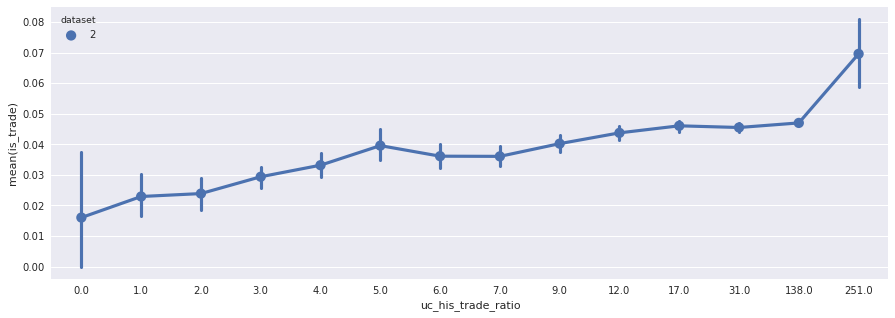

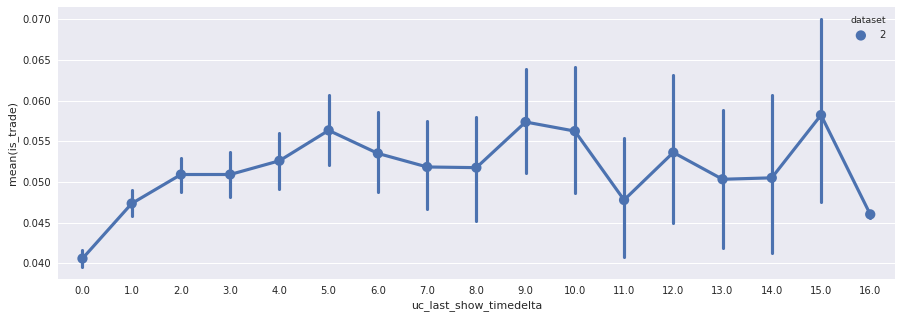

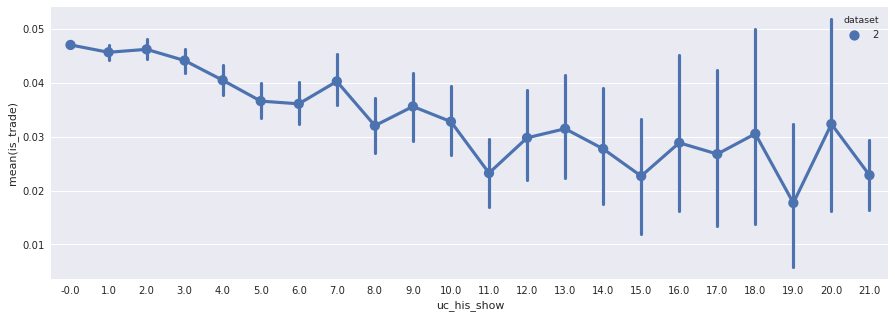

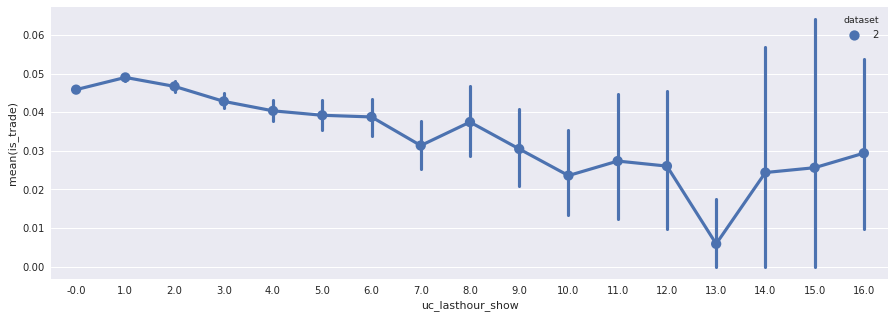

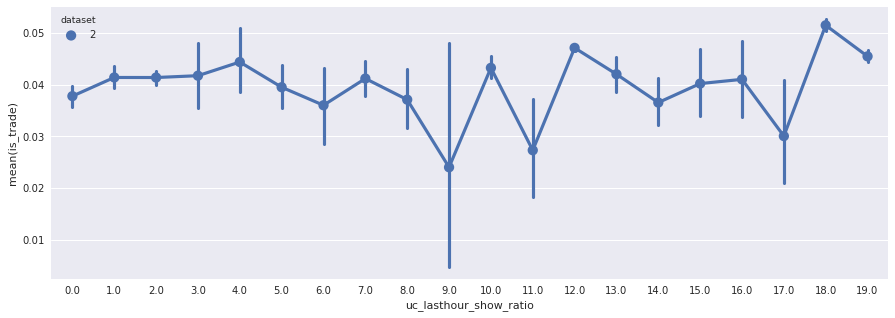

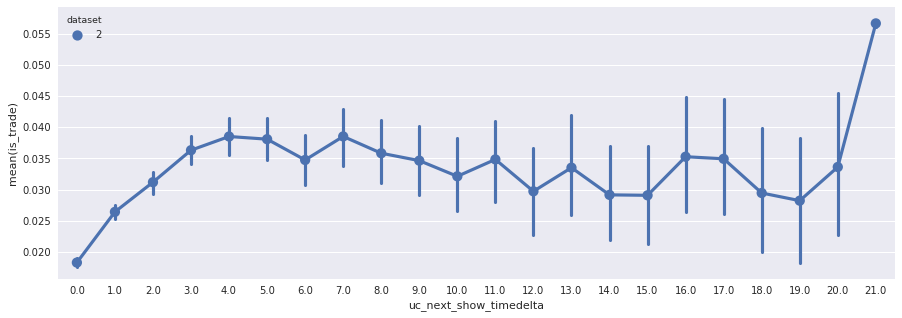

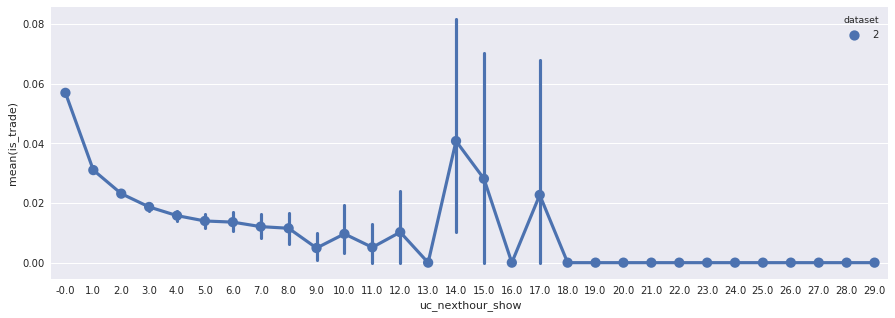

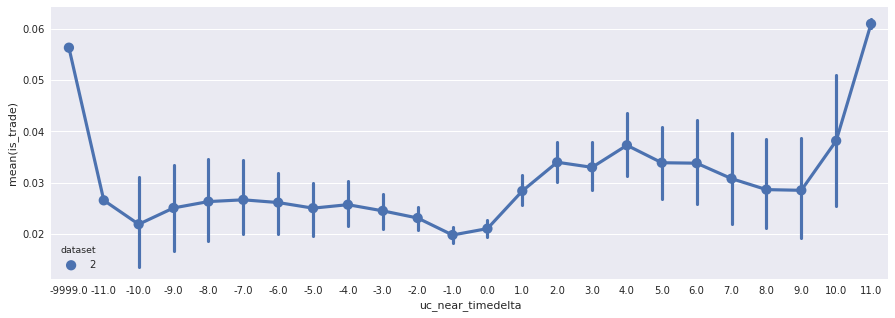

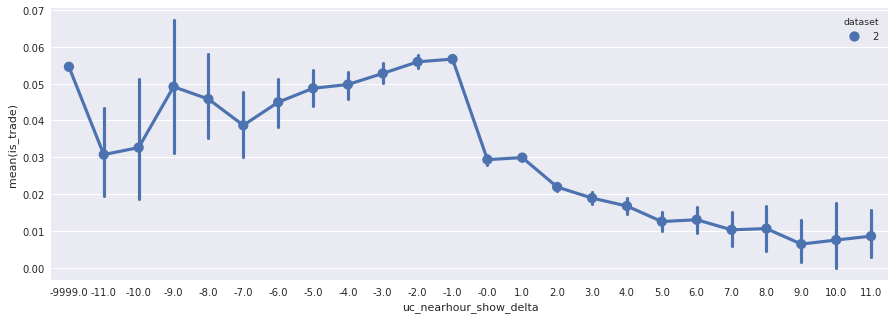

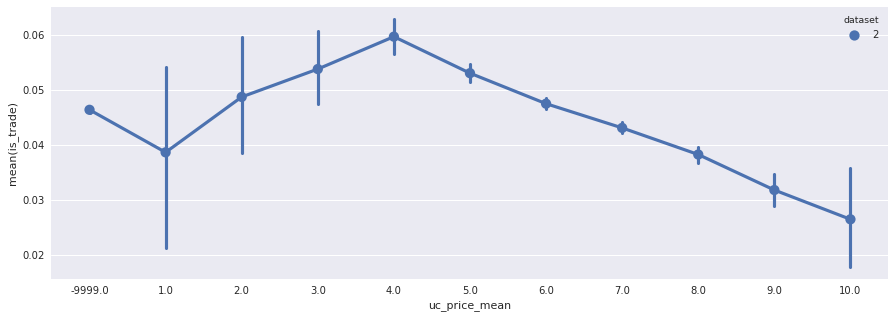

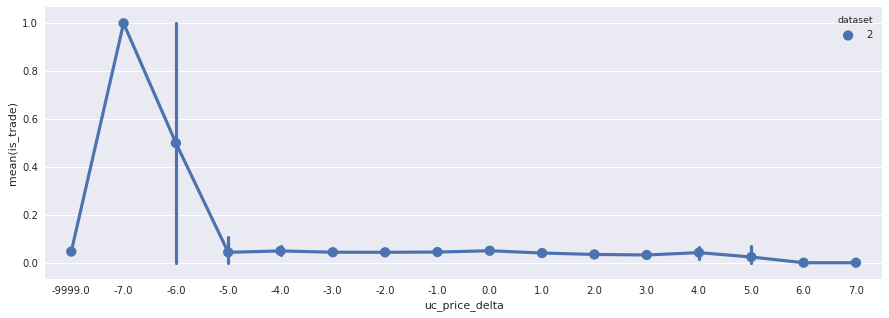

In [187]:
# 用户类别维度
tempDf = df.copy()
cols = ['uc_his_trade_ratio','uc_last_show_timedelta','uc_his_show','uc_lasthour_show','uc_lasthour_show_ratio',
        'uc_next_show_timedelta','uc_nexthour_show','uc_near_timedelta','uc_nearhour_show_delta',
        'uc_price_mean','uc_price_delta',]
print(getFeaPearsonr(tempDf, cols))
tempDf['uc_his_trade_ratio'] = tempDf['uc_his_trade_ratio'] // 0.0001
tempDf.loc[tempDf.uc_his_trade_ratio>250,'uc_his_trade_ratio'] = 251
# tempDf.loc[tempDf.uc_his_trade_ratio<3,'uc_his_trade_ratio'] = 2
tempDf['uc_last_show_timedelta'] = tempDf['uc_last_show_timedelta'] // 100
tempDf.loc[tempDf.uc_last_show_timedelta>15,'uc_last_show_timedelta'] = 16
tempDf['uc_his_show'] = tempDf['uc_his_show'] // 1
tempDf.loc[tempDf.uc_his_show>20,'uc_his_show'] = 21
tempDf['uc_lasthour_show'] = tempDf['uc_lasthour_show'] // 1
tempDf.loc[tempDf.uc_lasthour_show>15,'uc_lasthour_show'] = 16
tempDf['uc_lasthour_show_ratio'] = tempDf['uc_lasthour_show_ratio'] // 0.05
tempDf['uc_next_show_timedelta'] = tempDf['uc_next_show_timedelta'] // 100
tempDf.loc[tempDf.uc_next_show_timedelta>20,'uc_next_show_timedelta'] = 21
tempDf['uc_nexthour_show'] = tempDf['uc_nexthour_show'] // 1
tempDf['uc_near_timedelta'] = tempDf['uc_near_timedelta'] // 100
tempDf.loc[tempDf.uc_near_timedelta>10,'uc_near_timedelta'] = 11
tempDf.loc[tempDf.uc_near_timedelta<-10,'uc_near_timedelta'] = -11
tempDf['uc_nearhour_show_delta'] = tempDf['uc_nearhour_show_delta'] // 1
tempDf.loc[tempDf.uc_nearhour_show_delta>10,'uc_nearhour_show_delta'] = 11
tempDf.loc[tempDf.uc_nearhour_show_delta<-10,'uc_nearhour_show_delta'] = -11
tempDf['uc_price_mean'] = tempDf['uc_price_mean'] // 1
tempDf['uc_price_delta'] = tempDf['uc_price_delta'] // 1
tempDf.loc[tempDf.uc_price_delta>5,'uc_price_delta'] = 5
tempDf.loc[tempDf.uc_price_delta<-5,'uc_price_delta'] = -5
printSingleFeaLine(tempDf, cols)

                         pearsonr      p_values
ui_last_show_timedelta -0.0415718             0
ui_lasthour_show        0.0402946             0
ui_lasthour_show_ratio  0.0450066             0
ui_lastdate_show        0.0144599   6.48007e-51
ui_his_show             0.0105488   6.74874e-28
ui_next_show_timedelta  0.0451712             0
ui_nexthour_show        -0.035166  7.99556e-292
ui_nexthour_show_ratio -0.0179485    1.8458e-77
ui_near_timedelta        0.177648             0
ui_nearhour_show_delta  -0.202898             0
21.0    1033138
0.0       15297
1.0        9719
2.0        4848
3.0        2908
4.0        1984
5.0        1471
6.0        1126
7.0         939
8.0         771
9.0         660
10.0        577
12.0        526
11.0        521
13.0        434
14.0        397
16.0        342
17.0        338
15.0        332
19.0        299
18.0        288
20.0        260
Name: ui_last_show_timedelta, dtype: int64
-0.0    1037457
 1.0      35963
 2.0       3149
 3.0        464
 4.0        1

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


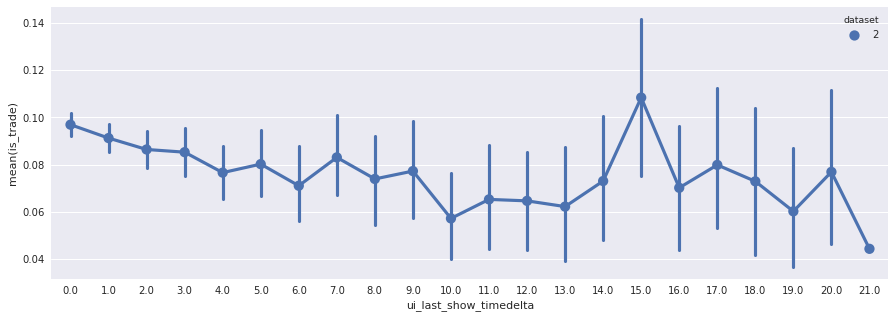

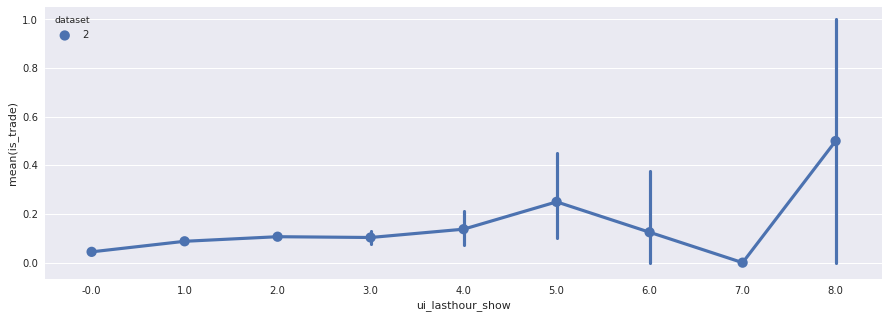

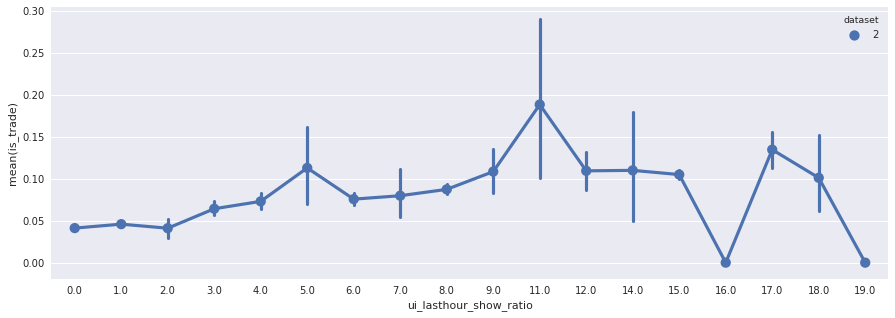

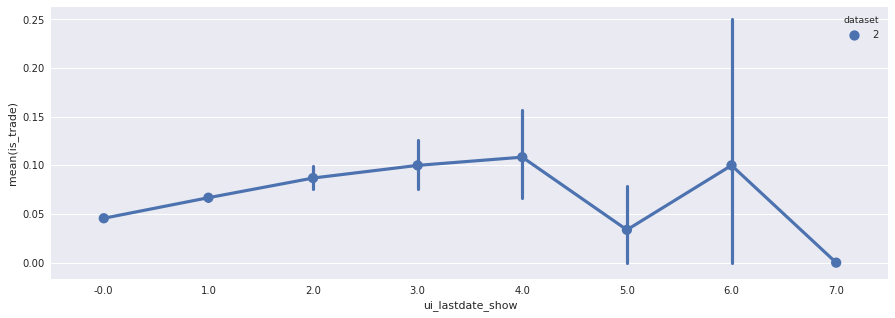

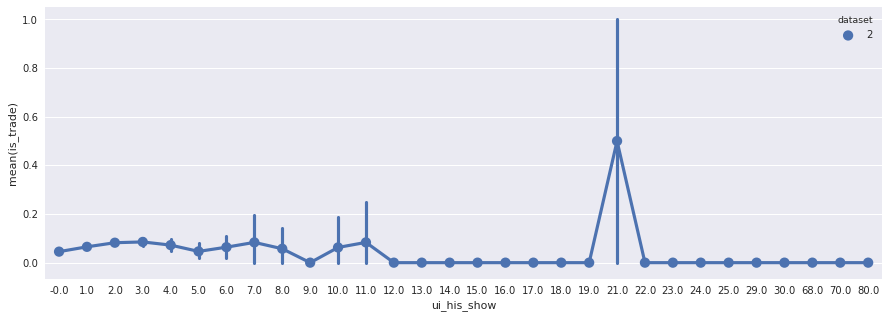

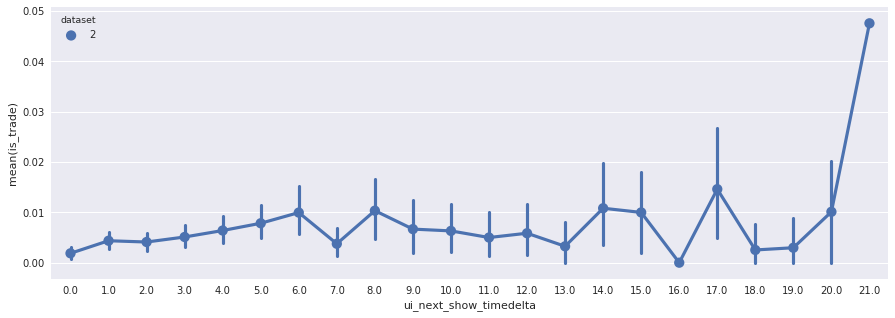

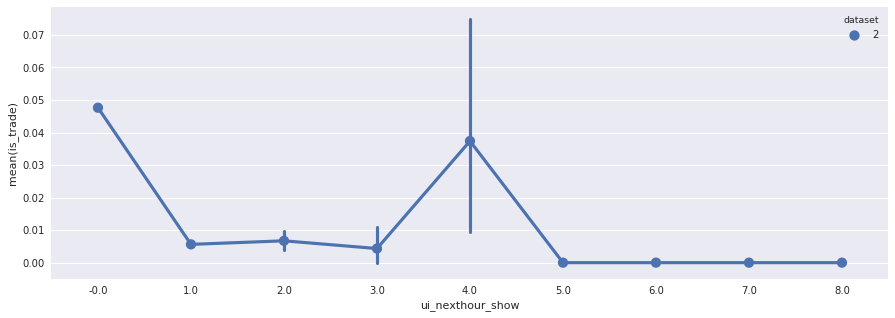

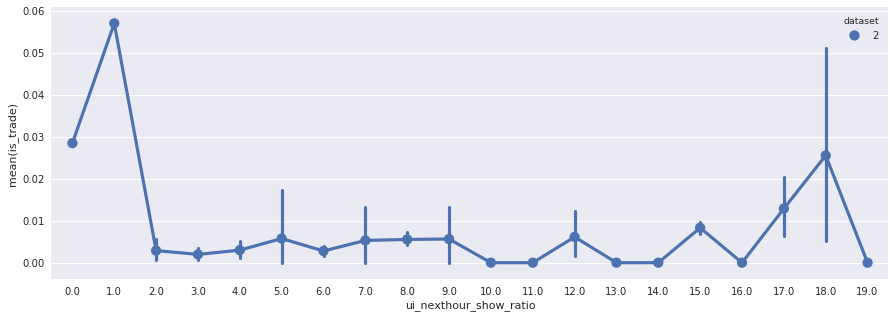

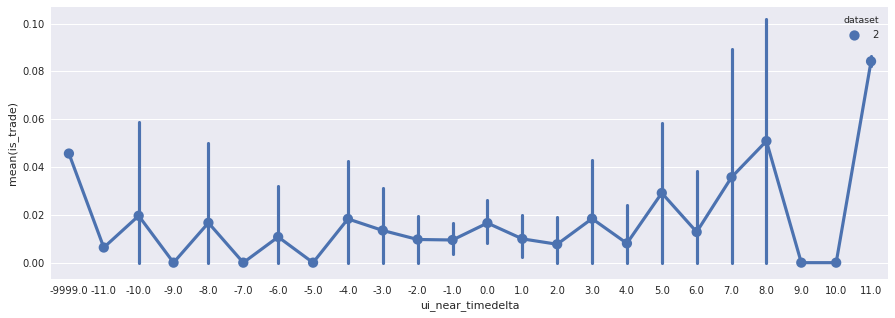

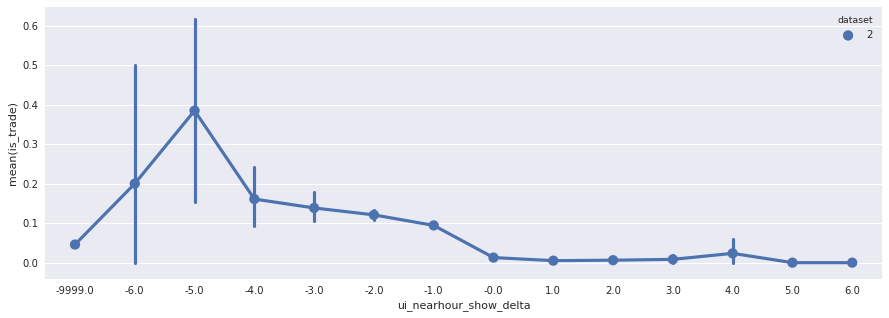

In [43]:
# 用户商品维度
tempDf = df.copy()
cols = ['ui_last_show_timedelta','ui_lasthour_show','ui_lasthour_show_ratio','ui_lastdate_show','ui_his_show',
        'ui_next_show_timedelta','ui_nexthour_show','ui_nexthour_show_ratio','ui_near_timedelta','ui_nearhour_show_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf['ui_last_show_timedelta'] = tempDf['ui_last_show_timedelta'] // 300
tempDf.loc[tempDf.ui_last_show_timedelta>20,'ui_last_show_timedelta'] = 21
tempDf['ui_lasthour_show'] = tempDf['ui_lasthour_show'] // 1
tempDf.loc[tempDf.ui_lastdate_show>6,'ui_lastdate_show'] = 7
tempDf['ui_lasthour_show_ratio'] = tempDf['ui_lasthour_show_ratio'] // 0.05
tempDf['ui_lastdate_show'] = tempDf['ui_lastdate_show'] // 1
tempDf['ui_his_show'] = tempDf['ui_his_show'] // 1
tempDf['ui_next_show_timedelta'] = tempDf['ui_next_show_timedelta'] // 100
tempDf.loc[tempDf.ui_next_show_timedelta>20,'ui_next_show_timedelta'] = 21
tempDf['ui_nexthour_show'] = tempDf['ui_nexthour_show'] // 1
tempDf['ui_nexthour_show_ratio'] = tempDf['ui_nexthour_show_ratio'] // 0.05
tempDf['ui_near_timedelta'] = tempDf['ui_near_timedelta'] // 300
tempDf.loc[tempDf.ui_near_timedelta>10,'ui_near_timedelta'] = 11
tempDf.loc[tempDf.ui_near_timedelta<-10,'ui_near_timedelta'] = -11
tempDf['ui_nearhour_show_delta'] = tempDf['ui_nearhour_show_delta'] // 1
tempDf.loc[tempDf.ui_nearhour_show_delta>5,'ui_nearhour_show_delta'] = 6
tempDf.loc[tempDf.ui_nearhour_show_delta<-5,'ui_nearhour_show_delta'] = -6
printSingleFeaLine(tempDf, cols)

                          pearsonr      p_values
us_his_show             0.00555806   7.99415e-09
us_his_trade_ratio      -0.0010645       0.26924
us_last_show_timedelta  -0.0303675  3.97872e-218
us_lasthour_show         0.0271876  3.11024e-175
us_lasthour_show_ratio   0.0361517  2.67214e-308
us_lastdate_show           0.01116   5.02391e-31
us_next_show_timedelta   0.0443995             0
us_nexthour_show        -0.0333419  1.54538e-262
us_near_timedelta         0.139072             0
us_nearhour_show_delta   -0.142135             0
-0.0     1025210
 1.0       38759
 2.0        8260
 3.0        2536
 4.0         993
 5.0         574
 6.0         257
 7.0         153
 8.0         124
 16.0         81
 9.0          57
 10.0         48
 14.0         33
 11.0         25
 12.0         25
 15.0         25
 13.0         15
Name: us_his_show, dtype: int64
24.0      1025210
1.0         38689
0.0         13139
1912.0         70
977.0          33
656.0          18
330.0           3
248.0         

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


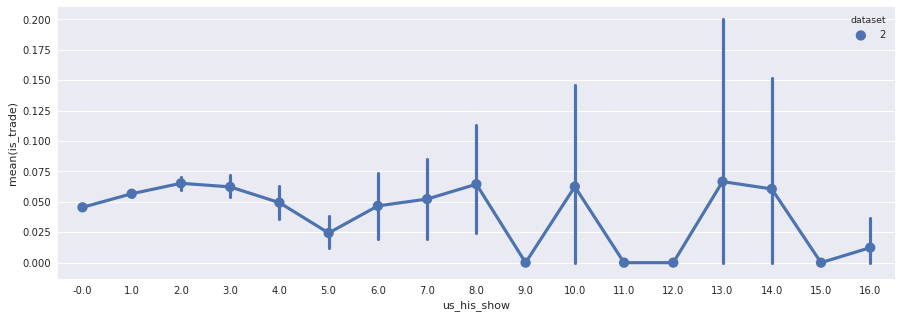

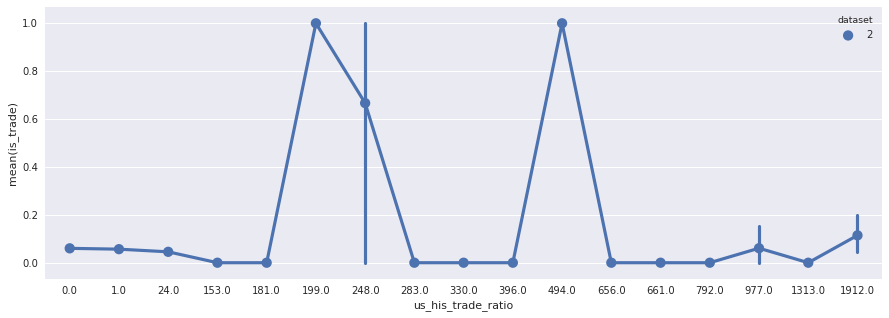

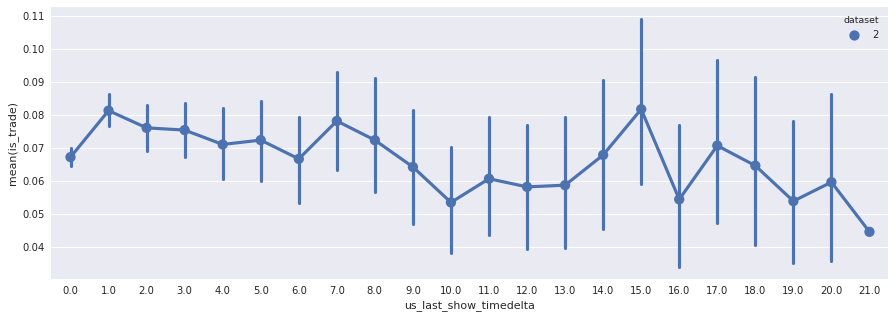

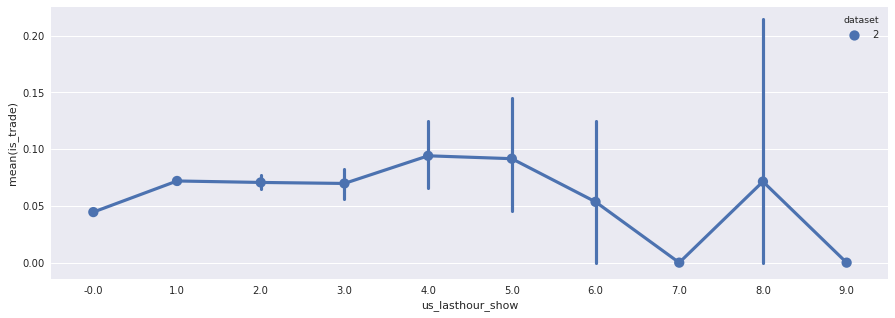

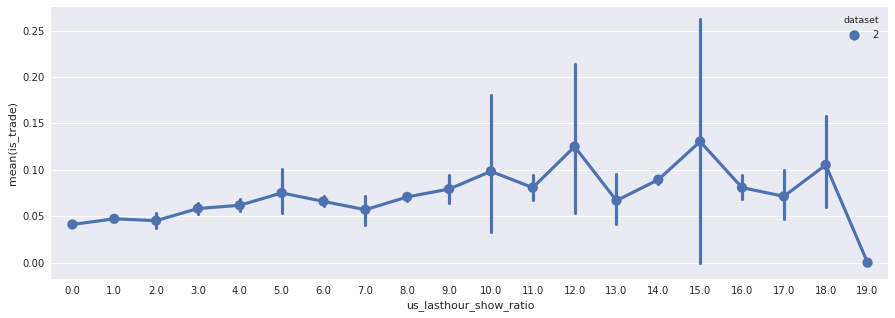

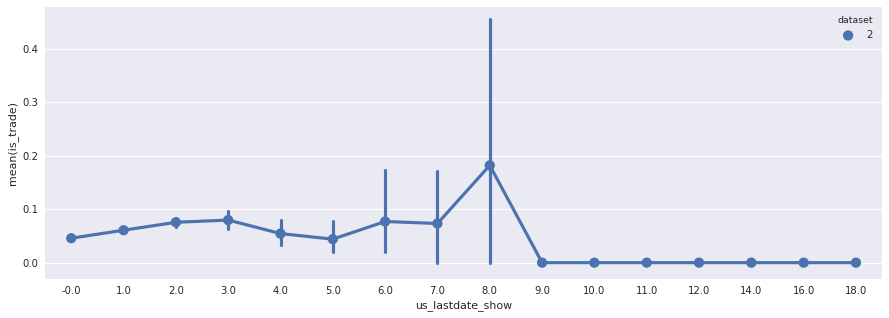

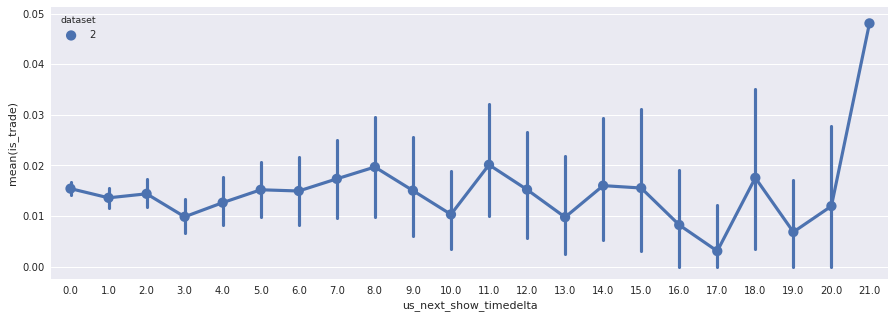

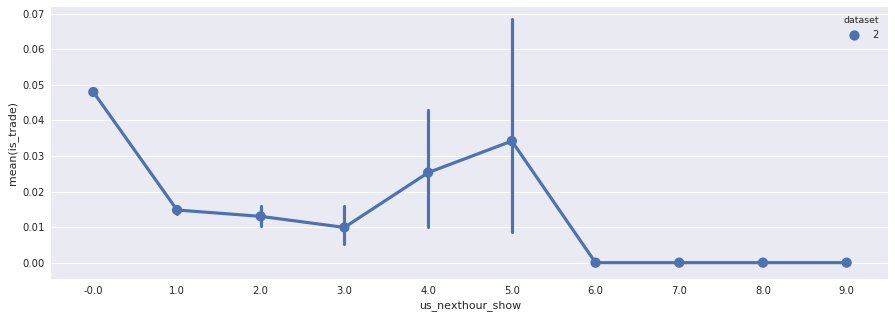

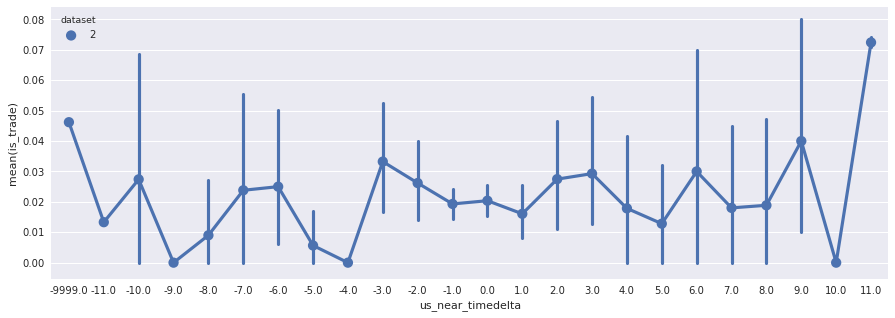

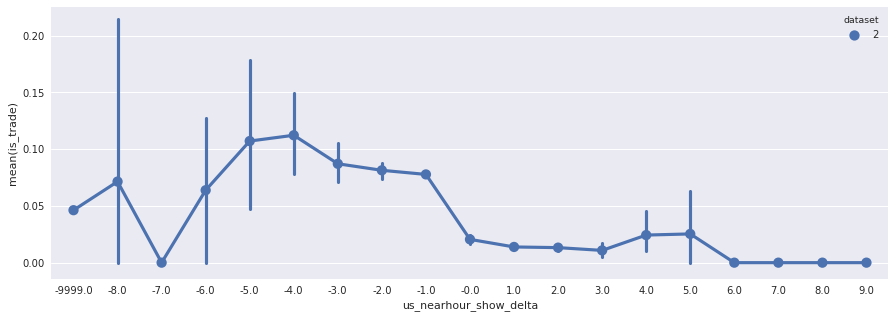

In [42]:
# 用户店铺交叉特征
tempDf = df.copy()
cols = ['us_his_show','us_his_trade_ratio','us_last_show_timedelta','us_lasthour_show','us_lasthour_show_ratio','us_lastdate_show',
        'us_next_show_timedelta','us_nexthour_show','us_near_timedelta','us_nearhour_show_delta',]
print(getFeaPearsonr(tempDf, cols))
tempDf['us_his_show'] = tempDf['us_his_show'] // 1
tempDf.loc[(tempDf.us_his_show>15),'us_his_show'] = 16
tempDf['us_his_trade_ratio'] = tempDf['us_his_trade_ratio'] // 0.0005
tempDf['us_last_show_timedelta'] = tempDf['us_last_show_timedelta'] // 300
tempDf.loc[(tempDf.us_last_show_timedelta>20),'us_last_show_timedelta'] = 21
tempDf['us_lasthour_show'] = tempDf['us_lasthour_show'] // 1
tempDf['us_lasthour_show_ratio'] = tempDf['us_lasthour_show_ratio'] // 0.05
tempDf['us_lastdate_show'] = tempDf['us_lastdate_show'] // 1
tempDf['us_next_show_timedelta'] = tempDf['us_next_show_timedelta'] // 300
tempDf.loc[(tempDf.us_next_show_timedelta>20),'us_next_show_timedelta'] = 21
tempDf['us_nexthour_show'] = tempDf['us_nexthour_show'] // 1
tempDf['us_near_timedelta'] = tempDf['us_near_timedelta'] // 600
tempDf.loc[(tempDf.us_near_timedelta>10),'us_near_timedelta'] = 11
tempDf.loc[(tempDf.us_near_timedelta<-10),'us_near_timedelta'] = -11
tempDf['us_nearhour_show_delta'] = tempDf['us_nearhour_show_delta'] // 1
printSingleFeaLine(tempDf, cols)

In [47]:
# 用户价格交叉特征
tempDf = df.copy()
cols = ['up_his_trade_ratio']
print(getFeaPearsonr(tempDf, cols))
tempDf['up_his_trade_ratio'] = tempDf['up_his_trade_ratio'] // 0.0001
printSingleFeaLine(tempDf, cols, plot=False)

                      pearsonr     p_values
up_his_trade_ratio  0.00826901  9.29969e-18
139.0     742549
23.0      136208
13.0       71199
8.0        40633
6.0        25240
3.0        17264
5.0        16326
4.0        10842
2.0         8587
1.0         4246
8320.0       821
4547.0       704
0.0          465
3128.0       462
2384.0       336
1926.0       276
1616.0       196
1391.0       130
1222.0       101
1089.0        94
982.0         72
821.0         57
895.0         52
759.0         36
705.0         28
618.0         26
659.0         20
582.0         18
4762.0        17
550.0         14
           ...  
2440.0         8
9082.0         8
1640.0         7
1787.0         7
311.0          7
1516.0         6
2779.0         6
1409.0         5
432.0          5
414.0          5
368.0          5
255.0          4
3227.0         4
451.0          4
397.0          4
496.0          3
1164.0         3
1100.0         2
1317.0         2
522.0          2
284.0          2
764.0          1
276.0      

                     pearsonr p_values
ca_his_trade_ratio  0.0881127        0
cg_his_trade_ratio  0.0830824        0
 1.0       455300
 0.0       188482
 3.0       170124
 2.0       141118
 4.0        58732
 5.0        35324
 7.0        13924
 8.0         7066
 6.0         4278
-9999.0      2296
 9.0          531
Name: ca_his_trade_ratio, dtype: int64
0.0    319296
1.0    276284
2.0    237742
3.0    156210
6.0     39680
4.0     27004
5.0     12544
7.0      8129
8.0       286
Name: cg_his_trade_ratio, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


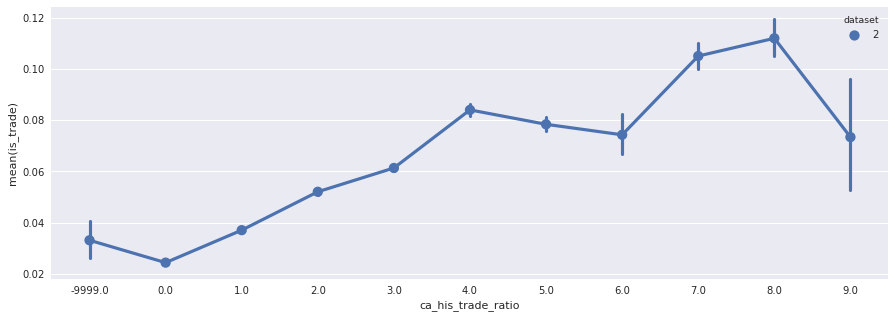

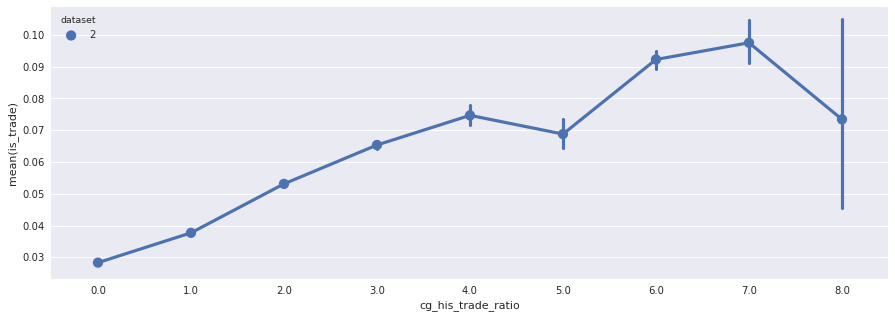

In [48]:
# 类别交叉特征
tempDf = df.copy()
cols = ['ca_his_trade_ratio','cg_his_trade_ratio']
print(getFeaPearsonr(tempDf, cols))
tempDf.loc[:,['ca_his_trade_ratio']] = tempDf[['ca_his_trade_ratio']] // 0.005
tempDf.loc[tempDf.ca_his_trade_ratio>15,'ca_his_trade_ratio'] = 16
tempDf.loc[:,['ca_his_show_ratio']] = tempDf[['ca_his_show_ratio']] // 0.05
tempDf.loc[:,['cg_his_trade_ratio']] = tempDf[['cg_his_trade_ratio']] // 0.005
tempDf.loc[tempDf.cg_his_trade_ratio>15,'cg_his_trade_ratio'] = 16
tempDf.loc[:,['cg_his_show_ratio']] = tempDf[['cg_his_show_ratio']] // 0.02
printSingleFeaLine(tempDf, cols)

                      pearsonr     p_values
ia_his_trade_ratio    0.078025            0
ia_his_show_delta  -0.00125466     0.193331
ia_his_trade_delta   0.0452124            0
ig_his_trade_ratio   0.0880061            0
ig_his_show_delta   -0.0156757  2.12782e-59
ig_his_trade_delta   0.0554508            0
 0.0       600540
 1.0       138710
 2.0       110195
 3.0        57476
 4.0        39187
 5.0        29463
 6.0        23611
 7.0        15098
 8.0        13727
 9.0        11635
 21.0        5975
 11.0        5907
 10.0        5494
 12.0        4116
 13.0        3038
 14.0        2320
-9999.0      2296
 15.0        1914
 17.0        1843
 16.0        1838
 19.0        1165
 18.0         907
 20.0         720
Name: ia_his_trade_ratio, dtype: int64
 0.0       229823
 1.0       215022
-1.0       177521
 2.0       151580
 3.0        86737
-2.0        82757
 4.0        38248
-3.0        38035
-4.0        17629
 5.0        15791
 6.0         7648
-5.0         6440
 7.0         3142
-6.0 

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


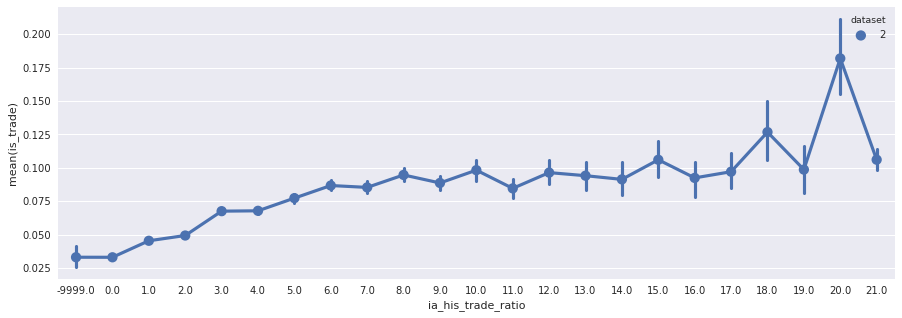

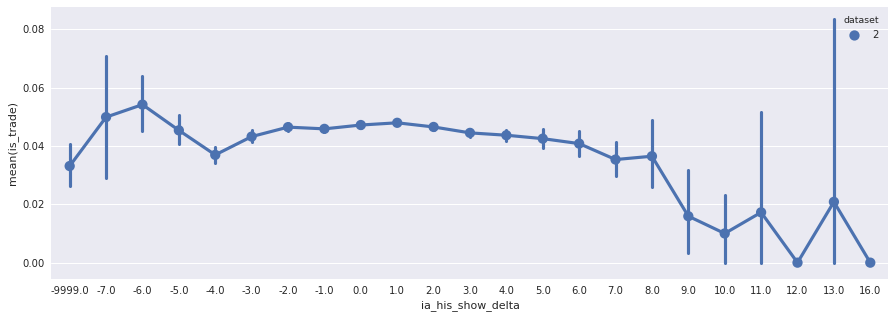

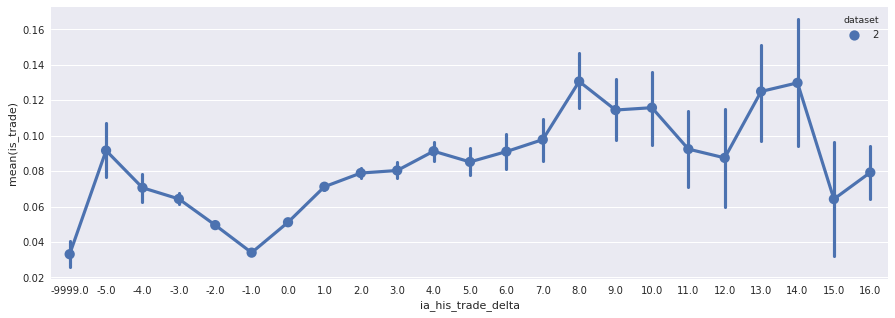

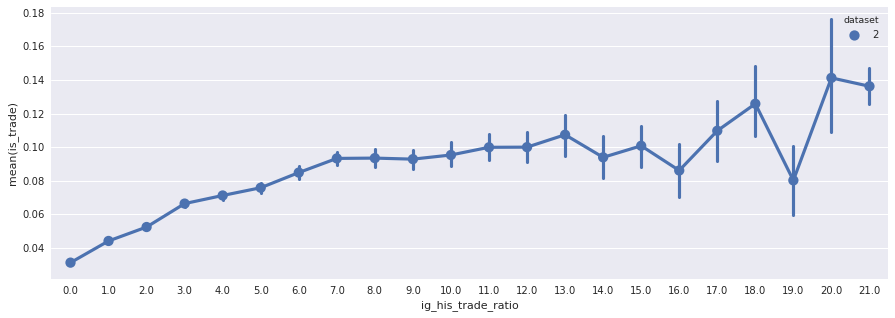

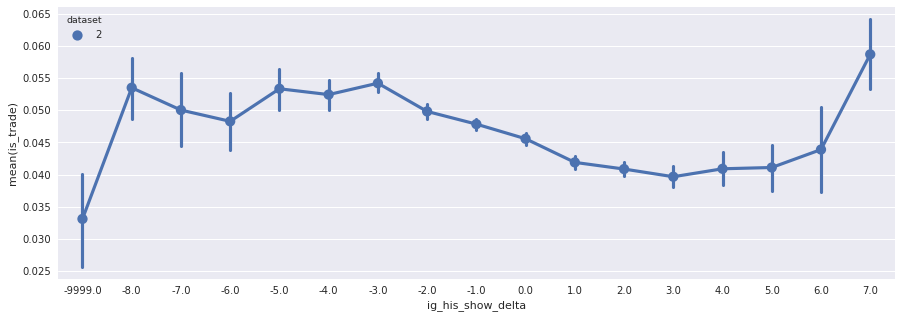

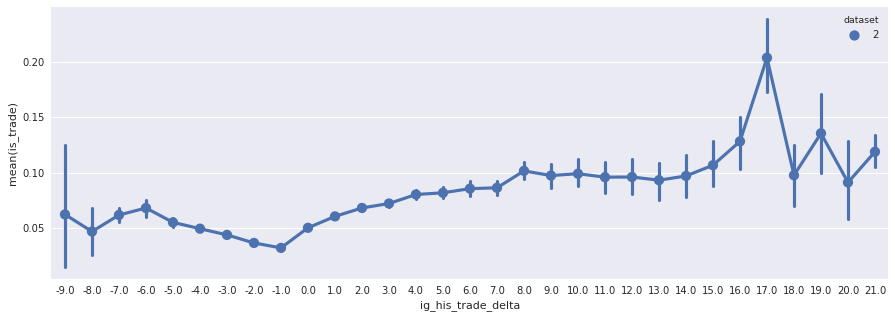

In [49]:
# 商品交叉特征
tempDf = df.copy()
cols = ['ia_his_trade_ratio','ia_his_show_delta','ia_his_trade_delta',
        'ig_his_trade_ratio','ig_his_show_delta','ig_his_trade_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf.loc[:,['ia_his_trade_ratio']] = tempDf[['ia_his_trade_ratio']] // 0.005
tempDf.loc[tempDf.ia_his_trade_ratio>20,'ia_his_trade_ratio'] = 21
tempDf['ia_his_show_delta'] = tempDf['ia_his_show_delta'] // 0.05
tempDf['ia_his_trade_delta'] = tempDf['ia_his_trade_delta'] // 0.01
tempDf.loc[(tempDf.ia_his_trade_delta>15),'ia_his_trade_delta'] = 16
tempDf.loc[:,['ig_his_trade_ratio']] = tempDf[['ig_his_trade_ratio']] // 0.005
tempDf.loc[tempDf.ig_his_trade_ratio>20,'ig_his_trade_ratio'] = 21
tempDf.loc[:,['ig_his_show_delta']] = tempDf[['ig_his_show_delta']] // 0.02
tempDf.loc[tempDf.ig_his_show_delta>6,'ig_his_show_delta'] = 7
tempDf.loc[tempDf.ig_his_show_delta<-7,'ig_his_show_delta'] = -8
tempDf['ig_his_trade_delta'] = tempDf['ig_his_trade_delta'] // 0.005
tempDf.loc[(tempDf.ig_his_trade_delta>20),'ig_his_trade_delta'] = 21
printSingleFeaLine(tempDf, cols)

                      pearsonr      p_values
ba_his_trade_ratio    0.078801             0
ba_his_show_delta   0.00471323   3.44195e-06
ba_his_trade_delta   0.0250826   8.3446e-135
bg_his_trade_ratio   0.0822453             0
bg_his_show_delta   -0.0202482   1.61384e-88
bg_his_trade_delta   0.0297569  2.53336e-189
 0.0       426337
 2.0       178878
 1.0       165159
-9999.0    106965
 3.0       101496
 4.0        27728
 5.0        19009
 6.0        16277
 7.0        11727
 8.0         7221
 9.0         3781
 10.0        3298
 11.0        2326
 12.0        1744
 14.0        1176
 21.0        1018
 13.0         778
 17.0         510
 15.0         503
 16.0         466
 18.0         367
 20.0         309
 19.0         102
Name: ba_his_trade_ratio, dtype: int64
 0.0       124380
-9999.0    106965
 1.0       104018
 2.0       100098
-1.0        96409
 3.0        86908
 4.0        69858
-2.0        69674
-3.0        60157
 5.0        45776
 6.0        37486
-4.0        32621
 7.0        2530

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


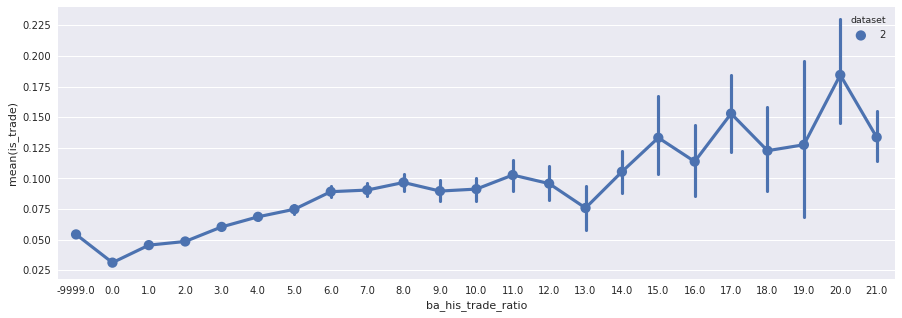

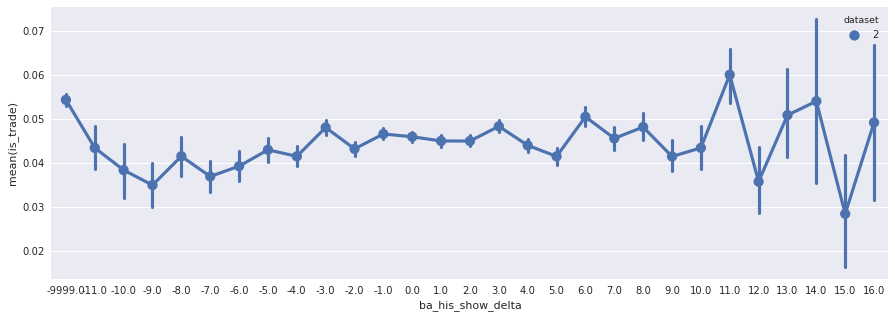

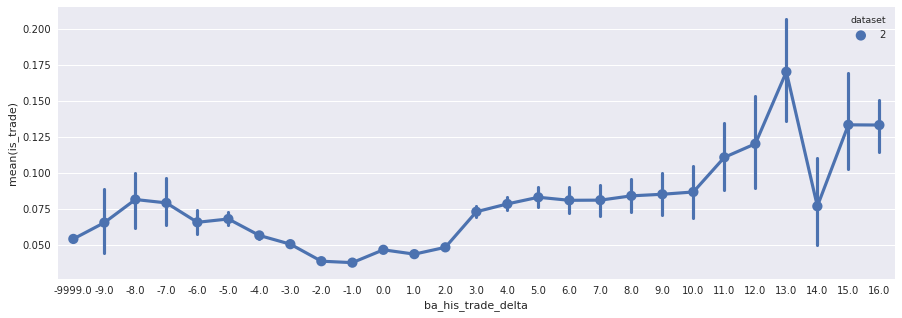

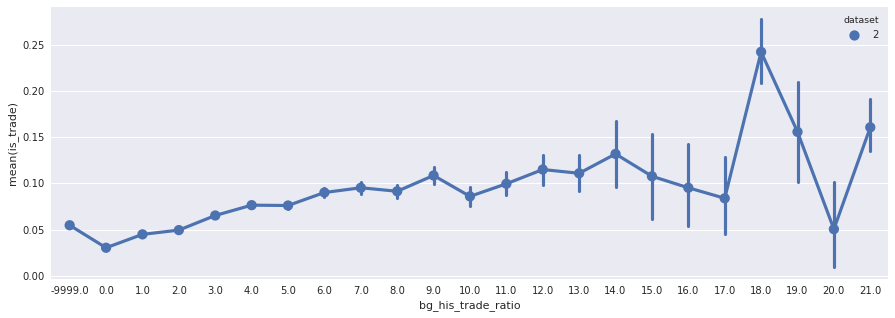

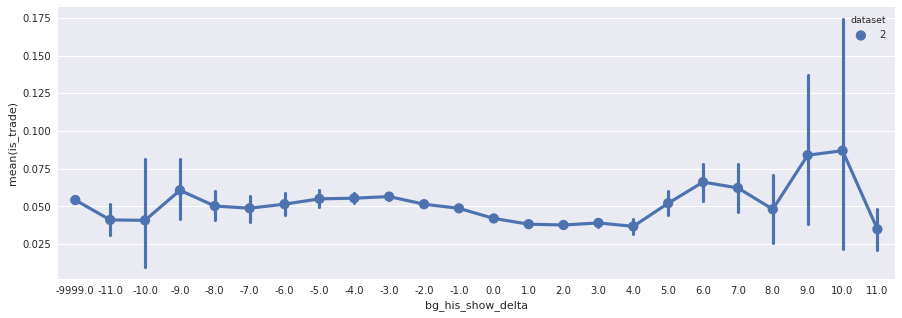

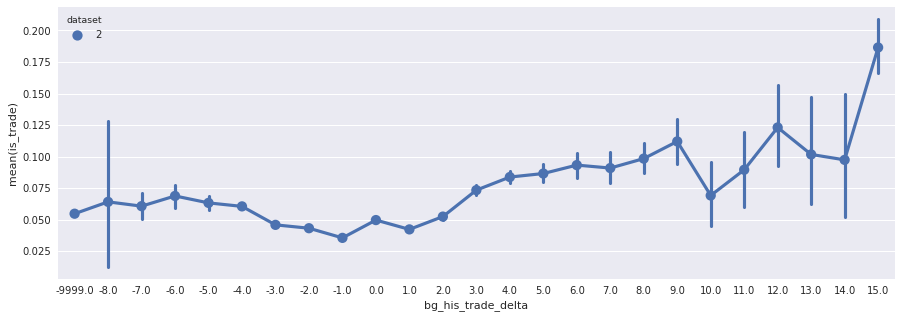

In [21]:
# 品牌交叉特征
tempDf = df.copy()
cols = ['ba_his_trade_ratio','ba_his_show_delta','ba_his_trade_delta',
        'bg_his_trade_ratio','bg_his_show_delta','bg_his_trade_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf['ba_his_trade_ratio'] = tempDf['ba_his_trade_ratio'] // 0.005
tempDf.loc[(tempDf.ba_his_trade_ratio>20),'ba_his_trade_ratio'] = 21
tempDf['ba_his_show_delta'] = tempDf['ba_his_show_delta'] // 0.02
tempDf.loc[tempDf.ba_his_show_delta>15,'ba_his_show_delta'] = 16
tempDf.loc[tempDf.ba_his_show_delta<-10,'ba_his_show_delta'] = -11
tempDf['ba_his_trade_delta'] = tempDf['ba_his_trade_delta'] // 0.005
tempDf.loc[tempDf.ba_his_trade_delta>15,'ba_his_trade_delta'] = 16
tempDf.loc[tempDf.ba_his_trade_delta<-9,'ba_his_trade_delta'] = -9
tempDf['bg_his_trade_ratio'] = tempDf['bg_his_trade_ratio'] // 0.005
tempDf.loc[(tempDf.bg_his_trade_ratio>20),'bg_his_trade_ratio'] = 21
tempDf['bg_his_show_delta'] = tempDf['bg_his_show_delta'] // 0.02
tempDf.loc[tempDf.bg_his_show_delta>10,'bg_his_show_delta'] = 11
tempDf.loc[tempDf.bg_his_show_delta<-10,'bg_his_show_delta'] = -11
tempDf['bg_his_trade_delta'] = tempDf['bg_his_trade_delta'] // 0.005
tempDf.loc[tempDf.bg_his_trade_delta>15,'bg_his_trade_delta'] = 15
tempDf.loc[tempDf.bg_his_trade_delta<-7,'bg_his_trade_delta'] = -8
printSingleFeaLine(tempDf, cols)